# Documentation for Hydra Multi-Asset Verification Test
ACTION_LIST = [['test_add', 'test_q_for_r', 'test_r_for_r','test_r_for_q', 'test_remove']]



## Model Description

The methodology for the tests is to create two universes - one for Hydra and one for Uniswap - to subsequently be able to represent sequences of actions on each side. As the Hydra system is unique in its design and has no counterpart yet for approprate comparisons the role of the benchmark will be fulfilled by assembling several Uniswaps together in a way that everything that can be done in Hydra can be accordingly reproduced. This allows next to compare the implications on both systems and ultimately assess the quantitative and qualitative differences of results and impacts on the Hydra system and its agents. 

This approach necessitates the definition and specification of two models:
   - 1 Hydra Omnipool model with one instance that is defined in line with the [Hydra Mathematical Specification](https://hackmd.io/M7OeWimITKGVxBDHGQa6gQ?view)
   - 1 Uniswap model with several instances that each are responsible for a particular mechanism
        - which of 1 instance is used for liquidity provision in asset $R_i$: this is modeled as a Uniswap of $R_i$ and $Q$
        - which of 1 instance is used for liquidity provision in asset $R_j$: this is modeled as a Uniswap of $R_j$ and $Q$
        - which of 1 instance is used for swaps between assets $R_i$ and $R_j$: this is modeled as a Uniswap of $R_i$ and $R_j$
        
![](https://i.imgur.com/yb6Zh3T.png)
        
## Test cases

A variety of testcases can be explored with this model resulting from a combination of the following parameters
   
   - Event: Add Liquidity, Remove Liquidity, Swap Asset, Swap Asset for Base
   - Asset: $R_i$, $R_j$, $R_k$, $Q$
   - Multiple Action Type: Alternating, $i$ only, $j$ only
   - Composite Action Type: Alternating, Trade Bias
   - Enable Symmetric Liquidity: True, False
    
In addition to these settings also a fee structure can be imposed:

   - Fixed Fee

## Test agents

The model specifies a number of eight agents that each have their local balances, can interact with the system and are modeled to be responsible for **one action only**. This allows to track for each testcase how the balances will develop and to show independently which events will trigger changes to local and global states. Most importantly directly and indirectly affected variables can be easily identified.

Two dataframes of agents are initialized identically for both the Uniswap and the Hydra world and then work their way through on each side according to the testcase. Afterwards the effects on both sides can be compared.

![](https://i.imgur.com/r9IAJMr.png)



## Composite Action Tests

Besides being able to test all mechanisms individually also compositions of actions can be performed. This means selecting and combining two from the above testcases and letting the respective agents take the actions repeadetly. A composition action test therefore is defined as two actions which each can be a combination of *event* and *asset* selected from the list of testcases above, for example:
- Add liquidity in $R_i$ and Add liquidity in $R_j$
- Add liquidity in $R_i$ and Swap $R_i$ for $Q$
- Remove liquidity in $R_j$ and Swap $R_i$ for $Q$
- ...

In total there would be 28 composit pairs which can be derived from this decision tree:
selecting any one of the four primitive mechanisms of: **trade in/out** or **add/remove liquidity** of some given asset and then the subsequent action could be the three remaining mechanisms of the same asset or doing anyone of the four mechanisms in another asset.  

These basic combinations can be explored before further proceeding with
- trade sizes,
- trade frequencies,
- randomization,...



# Testcase in this notebook


This notebook documents the results of the following experiment:
- **Action 1**: One agent adds liquidity in XX
- **Action 2**: Another agent trades XX for XX.

which is a reslt of the following settings:

- exo_trade = ['test_q_for_r'] # agent 0
- exo_liq = ['test_add'] # agent 3
- exo_asset = ['alternating']
- exo_composite = ['alternating'] 

## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

## Introduction to Hydra
>Hydra is an automated market maker that generalizes the concept of Uniswap and Balancer to a) an arbitrary number of dimensions and b) a variant weight distaribution of assets in the pool that changes in accordance with action sequences in the pool. Anyone can become a liquidity provider, and invest in the 'Omnipool'. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://hydradx.io/

There is a predefined set of (_mechanisms_) in which an agent can interact with an the Hydra Protocol :
1. `addLiquidity`: deposit a risk asset in the omnipool; mint HDX tokens - "shares" of this risk asset - in exchange;
1. `removeLiquidity`: burn HDX tokens; withdraw a proportional amount of the risk asset in exchange;
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" 
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Hydra takes the corresponding amount of "token A" from the user account 



## Model File structure

The folder **model** contains:

 - a file config.py: 

    This file configures the simulation experiments by setting the number of monte carlo runs, the number of timesteps for the simulation and the simulation parameters. It also aggregates the partial states and the initial state variables.
    
    The purpose of this file is to *configure and initialize* the experiment.
    
    
 - a file partial_state_update_block.py

    This file defines each partial state update block individually. This feature allows cadCAD to divide each simulation timestep into several 'blocks' where different state variables are mutated conditioned upon the policy input.
    
    In the current setting 
    - the first block maps the user action to the appropriate mechanism in the uniswap world
    - the second block maps the user action to the appropriate mechanism in the hydra world
    - the third block resolves the quantities of HDX and weights in the hydra world
    - the forth block calculates the metrics: the swap prices in the uniswap world and the pool prices in the hydra world

    This file corresponds to the system specification diagram, where each column is one partial state update block 
    
    The purpose of this file is to *define* the sequence and details of state updates for each simulation timestep. The relevant mechanisms are imported from the files in the **parts** folder
    
    
 - a file plot_utils.py

    This file defines all plot functions that can be called in the jupyter notebook to visualize the results. In general there are three types of plots:
    - plots related to the uniswap world (do not contain the word 'hydra')
    - plots related to the hydra world (contain the word 'hydra')
    - general plots applicable to both worlds (f.e Impermanent Loss)

    It also can be distinguished between plots related to global system variables and local agent variables:
    - global variables (do not contain the word 'agent')
    - local variables (contain the word 'agent')

    The purpose of this file is to *define* the way how particular properties can be plotted over time.
    

 - a file run.py

    This file *defines* the run and postprocessing methods and is used to execute the simulation run:
    - run() is used to execute the simulation and create a dataframe
    - postprocessing is used to extract relevant metrics from the simulation output in the dataframe

     The purpose of this file is to *execute* the simulation and *create* metrics.
     
     
 - a file state_variables.py

    This file *sets* the number of agents and *defines* the local (agent-level) state variables, *sets* the number of assets and *defines* the global (system-state) variables of the system, *computes* the prices of the assets and *defines* the initial state object
    - the agent states describe their holdings of assets that agents have contributed to the pool or still hold outside as well as their quantities of shares they received for their contribution
    - the global states describe the quantities of assets in the system
    - price variables are computed from the states both in the uniswap and hydra world
    - the initial state object consists of 
        - two agent dataframes, one for each world respectively
        - two sets of global variables, one for each world respectively
        - prices for each world (? is pool = prices ?)

    The purpose of this file is to *define* the global and local states of the system.
    
    
 - a file sys_params.py

    This file *contains* the system parameters and allows to select items from a list for them. Following parameters can be defined:
    - trade action type
    - liquidity action type
    - multiple asset action type
    - composite action type
    - liquidity add type (symmetry)

    In addition the following is set
    - initial values for assets 
    - hard coded fee value
    - choice of the system parameters from the list above
    

 - a folder **parts** which itself contains general files relevant for both instances, files related specifically to Uniswap and files related specifically to Hydra 
      - [action.py](model/parts/action.py)
       This is an action dictionary which drives the model. As there are no behavioral assumptions in the model yet, currently actions are prescribed actions in testing mode derived from events. However, action schema respects https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange as much as possible, allowing for future analysis against uniswap transaction datasets.
        This file contains a function called 'actionDecoder' which takes its inputs from the file sys_params.py and maps those encoded events to agent actions. At first an arbitrary action dictionary is defined which then is adapted according to the choices of system parameters. In particular relevant are the parameter definitions of the asset, the composite and whether there is a trade or liquidity event defined.
        
    - [uniswap.py](model/parts/uniswap.py)
     Reads in action output and directs the action to the appropriate Uniswap mechanism for each corresponding Uniswap instance. Currently there are two instances in place, namely the R_i<>Q pair and the R_j<>Q pair. Both instances have their respective requisite state variables: UNI_Qx, UNI_Rx, and UNI_Sx.

    - [utils.py](model/parts/utils.py)
    Computes the state update for each Uniswap state variable and outputs the updated global state variables.
        
     - [agent_utils.py](model/parts/agent_utils.py)
     Computes the corresponding agent local state for each Uniswap agent resolving their action and outputs the updates local state variables.

      -  [hydra.py](model/prts/hydra.py)
     Reads in action output and directs the action to the appropriate Hydra mechanism for each state variable: Q, Sq, and pool.
    
      - [hydra_utils.py](model/parts/hydra_utils.py)
     Computes the state update for each Hydra state variable

    -  [asset_utils.py](model/parts/asset_utils.py)
     Computes the state update for each Reserve Asset in a Hydra Omnipool

    -  [hydra_agent_utils_class.py](model/parts/hydra_agent_utils_class.py)
     Computes the corresponding agent local state for each Hydra agent resolving their action and outputs the updates local state variables.
     
     #### The interrelations between the files are shown here:
     
    ![](https://i.imgur.com/mNhfQE4.png)



# Testcase Definition

#### Block 1:

| #   |   Run   | a  | $\mu_i$ |          $\sigma_i$          | $\mu_j$ |          $\sigma_j$          | $\mu$ | $\sigma$ | Total runs         |
| --- |:-------:|:-------:|:-------:|:----------------------------:|:-------:|:----------------------------:| ----- | -------- | ------------------ |
| 1   | 001-100 |   0.5   |   $L$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $L$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 2   | 101-200 |   0.5   |   $L$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $L$   | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |
| 3   | 201-300 |    1    |   $L$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $L$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 4   | 301-400 |    1    |   $L$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $L$   | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |
| 5   | 401-500 |   1.5   |   $L$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $L$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 6   | 501-600 |   1.5   |   $L$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $L$   | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |

All tests in block 1 are performed for **each combination** of $\mu_i$ and $\mu_j$ selectable from $L$ which results in $100$ runs; where 

$\mu_i \in L =\{10.000, 25.000, 50.000, 75.000, 100.000, 250.000, 500.000, 750.000, 1.000.000, 2.000.000 \}$

and

$\mu_j \in L =\{10.000, 25.000, 50.000, 75.000, 100.000, 250.000, 500.000, 750.000, 1.000.000, 2.000.000 \}$

### Goals for Friday:
- Having one notebook that runs block 1 in its entirety and presents the results as a general descriptive analysis

### Experiment for Friday:

I want to have:
- 600 runs through the model for experiments 1-6
- In these experiments there should be 
    - one agent (nr 2) adding liquidity and removing it afterwards
    - one agent (nr 5) randomly trading in between
- This runs should be performed for 
- 1 notebook that would show in fan plots how Uniswap & Hydra instances perform for these 600 runs
- select which runs would make sense for that

## Run Model

The following command lines import all packages, experiments and run the model 

This is the execution of cadcad. This writes the config object, does the execution and returns the rdf - which is a data object that shows the rows and columns of results in a dataframe

Here is one additional option as well. The postprocessing causes the index of the results to be every forth because of the cadcad architecture where the partial state updates are the substeps. With this option selected we see only the end of each timestep - the last substep. Therefore only final results are shown. To get a line for each substep the postprocessing needs to be deactivated. 

In [1]:
from model.config_wrapper import ConfigWrapper

from model import run_wrapper
from cadCAD import configs

# parametric_experiment = ConfigWrapper()
# get_keys = parametric_experiment.get_config()
# get_keys[0]['M']
# parametric_experiment.get_config()

In [2]:
import model as model


In [3]:
parametric_experiment = ConfigWrapper(model)


running file: asset_utils.py
end of file: asset_utils.py
running file: partial_state_update_block.py
running file: action_list.py
end of file: action_list.py
end of file: partial_state_update_block.py


In [4]:
del configs[:]

parametric_experiment.append()

In [34]:
get_keys = parametric_experiment.get_config()
get_keys[2]['M']

{'fee_numerator': 997,
 'fee_denominator': 1000,
 'exo_trade': 'test_r_for_r',
 'exo_liq': 'pass',
 'ENABLE_SYMMETRIC_LIQ': True,
 'exo_asset': 'i_only',
 'exo_composite': 'alternating',
 'Ki': 10000000,
 'ACTION_LIST': ['test_add', 'test_r_for_r', 'test_remove'],
 'CHANGE_LOG': '4-01-21',
 'a': 1.5,
 'ENABLE_BALANCER_PRICING': True,
 'exo_trade_size': 'vary_size',
 'mu': 1000,
 'sigma': 500,
 'exo_random_sequence': 'on'}

In [6]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

# df = run.run()
# rdf = run.postprocessing(df)
# rdf = df # debugging substeps
# pd.set_option("mode.chained_assignment", None)


running file: run.py
end of file: run.py


In [7]:
(data, tensor_field, sessions) = run_wrapper.run(drop_midsteps=True)

experiments = data
experiments1 = data



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 16, 3, 22)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 1, 1, 1]
SubsetIDs: [0, 1, 2, 0, 1, 2]
Ns       : [0, 1, 2, 0, 1, 2]
ExpIDs   : [0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
timestep timestep  0
asset_id  i
q_sold  10
ri_sold  10
getting here on 0
getting in on 0
skipping on 0
0 1 2 2 4 5
0 pass test_r_for_r i
I want to trade:
 0
asset_id  i
q_sold  10
ri_sold  10
getting here on 0
getting in on 0
skipping on 0
0 1 2 2 4 5
0 pass test_r_for_r j
I want to trade:
timestep timestep  1
asset_id  i
q_sold  10
ri_sold  10
getting here on 1
getting in on 1
skipping on 1 1
asset_id  i
q_sold  10
ri_sold  10
getting here on 1
getting in on 1
skipping

timestep  16
0 1 2 2 4 5
16 pass test_r_for_r i
I want to trade:
here
not here
timestep  16
asset_id  j
q_sold  658
ri_sold  658
getting here on 16
getting in on 16
skipping on 16
0 1 2 2 4 5
16 pass test_r_for_r i
I want to trade:
timestep  17
asset_id  j
q_sold  658
ri_sold  658
getting here on 17
getting in on 17
skipping on 17
0 1 2 2 4 5
17 pass test_r_for_r i
I want to trade:
here
not here
timestep  1717
asset_id  i
q_sold  1080
ri_sold  1080
getting here on 17
getting in on 17
skipping on 17
0 1 2 2 4 5
17 pass test_r_for_r j
I want to trade:

timestep  18
asset_id  i
q_sold  1080
ri_sold  1080
getting here on 18
getting in asset_id  i
q_sold  972
ri_sold  972
getting here on 17
getting in on 17
skipping on 17
0 1 2 2 4 5
17 pass test_r_for_r j
I want to trade:
timestep on 18
skipping on 18
0 1 2 2 4 5
18 pass test_r_for_r i
I want to trade:
here
not here
timestep  18
asset_id  j
q_sold  555
ri_sold  555
getting here on 18
getting in on 18
skipping on 18
0 1 2 2 4 5
18 pass test

skipping onskipping on 34
0 1 2 2 4 5
 34
0 1 2 2 4 534 pass test_r_for_r j
I want to trade:

timestep  35
asset_id  i
q_sold  1960
ri_sold  1960
getting here on 35
getting in on34 pass test_r_for_r i
I want to trade:
timestep  35
asset_id  j
q_sold  930
ri_sold  930
getting here on 35
 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r i
getting in on 35
skipping on 35
I want to trade:
here0 1 2
not here
timestep  35
asset_id  j
q_sold  976
ri_sold  976
getting here on 35
getting in on 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r j
I want to trade:
timestep  2 4 5
35 pass test_r_for_r j
I want to trade:
here
not here
timestep  36
asset_id  j
q_sold  976
ri_sold  976
getting here on 36
getting in on 36
skipping on 36
0 1 2 2 4 5
36 pass test_r_for_r i
I want to trade:
here 35
asset_id  j
q_sold  1947
ri_sold  1947
getting here on 35
getting in on 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r i
I want to trade:
timestep  36
asset_id  j
q_sold  1947
ri_sold  1947
getting here 

timestep 47 50
asset_id  i
q_sold  829
ri_sold  829
getting here on 50
getting in on 50
skipping on 50
0 1 2 2 4 5
50 pass test_r_for_r j
I want to trade:
here

not here
timestep  50
asset_id  j
q_sold  811
ri_sold  811
getting here on 50
getting in on 50
skipping on 50
0 1 2 2 4 5
50 pass test_r_for_r j
I want to trade:
timestep getting in on 47
skipping on 47
0 1 2 2 4 5
47 pass test_r_for_r i
I want to trade:
timestep  51
asset_id  j
q_sold  811
ri_sold  811
getting here on 51
getting in on 51
skipping on 51
0 1 2 2 4 5
51 pass test_r_for_r j
I want to trade:
here 
not here
timestep 48
asset_id  j
q_sold  1885
ri_sold  1885
getting here on 48
getting in on  51
asset_id  i
q_sold  438
ri_sold  438
getting here on 51
getting in on 51
skipping on 51
0 1 2 2 4 5
51 pass test_r_for_r j
48I want to trade:

skipping on 48
0 1 2 2 4 5
48 pass test_r_for_r i
I want to trade:
here
not here
timestep  48
asset_id  i
q_sold  838
ri_sold  838
getting here on 48
getting in on 48
skipping on 48
0 1

timestep 
timestep  62
asset_id  j
q_sold  1000
ri_sold  1000
getting here on 62
getting in on 62
skipping on 62
0 1 2 2 4 5
62 pass test_r_for_r j
I want to trade:
timestep   63
asset_id  j
q_sold  1000
ri_sold  1000
getting here on 63
getting in on 63
skipping on 63
0 1 2 2 4 5
63 pass test_r_for_r i
I want to trade:
here
not here
timestep  63
asset_id  i
q_sold  729
ri_sold  729
getting here on 63
getting in on 63
skipping on 63
0 1 2 2 4 5
63 pass test_r_for_r j
I want to trade:
timestep 64 64
asset_id  i
q_sold  729
ri_sold  729
getting here on 64
getting in on 64
skipping on 64
0 1 2 2 4 5
64 pass test_r_for_r j
I want to trade:
here
not here
timestep 
 64
asset_id  j
q_sold  680
ri_sold  680
getting here on 64
getting in on 64
skipping on 64
0 1 2 2 4 5
64 pass test_r_for_r i
I want to trade:
asset_id  j
q_sold  1054
ri_sold  1054
getting here on 64
getting in on 64
skipping on 64
0 1 2 2 4 5
64 pass test_r_for_r j
timestep I want to trade: 65
asset_id  j
q_sold  680
ri_sold  68

0 1 2 2
skipping on 79
0 1 2 2 4 5
79 pass test_r_for_r j
I want to trade:
here 
not here
timestep  79
asset_id  j
q_sold  1401
ri_sold  1401
getting here on 79
getting in on 79
skipping on 79
0 1 2 2 4 5
79 pass test_r_for_r i
I want to trade:
timestep 4 5
78 pass test_r_for_r j
I want to trade:
timestep  80
asset_id  j
q_sold  1401
ri_sold  1401
getting here on 80
getting in on 80
skipping on 80
0 1 2 2 4 5
80 pass test_r_for_r j
I want to trade:
here 
not here
timestep  80
asset_id  i
q_sold  1222
ri_sold  1222
getting here on 80
getting in on 80
skipping on 80
0 1 2 2 4 5
80 pass test_r_for_r j
I want to trade:
timestep 79 81
asset_id  i
q_sold  1222
ri_sold  1222
getting here on 81
getting in on 81
skipping on 81
0 1 2 2 4 5
81 pass test_r_for_r i
I want to trade:
here
not here
timestep  81
asset_id  i
q_sold  1087
ri_sold  1087
getting here on 81
getting in on 81
skipping on 81
0 1 2 2 4 5
81 pass test_r_for_r i
I want to trade:

timestep asset_id  i
q_sold  1110
ri_sold  1110
ge

94 pass test_r_for_r  test_r_for_r j
I want to trade:
timestep  95
asset_id  j
q_sold  1385
ri_sold  1385
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
herej
I want to trade:
timestep 
not here
timestep  95
asset_id  i
q_sold  874
ri_sold  874
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
 95
asset_id  i
q_sold  1113
ri_sold  1113
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
here
not here
timestep  95
asset_id  i
q_sold  1508
ri_sold  1508
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r i
I want to trade:
timestep timestep  96
asset_id  i
q_sold  1508
ri_sold  1508
getting here on 96
getting in on 96
skipping on 96
0 1 2 2 4 5
96 pass test_r_for_r j
I want to trade:
here 
not here
timestep  96
asset_id  i
q_sold  1226
ri_sold  1226
getting here on 96
getting in on 96
skipping on 96

0 1 2 2 4 5
11 pass test_r_for_r j
I want to trade:
here
not here
timestep  11
asset_id  j
q_sold  -53
ri_sold  -53
getting here on 11
getting in on 11
skipping on 11
0 1 2 2 4 5
11 pass test_r_for_r j
I want to trade:
timestep  12
asset_id  j
q_sold  -53
ri_sold  -53
getting here on 12
getting in on 12
skipping on 12
0 1 2 2 4 5
12 pass test_r_for_r i
I want to trade:
here
not here
timestep  12
asset_id  i
q_sold  1628
ri_sold  1628
getting here on 12
getting in on 12
skipping on 12
0 1 2 2 4 5
12 pass test_r_for_r i
I want to trade:
timestep  13
asset_id  i
q_sold  1628
ri_sold  1628
getting here on 13
getting in on 13
skipping on 13
0 1 2 2 4 5
13 pass test_r_for_r i
I want to trade:
here
not here
timestep  13
asset_id  i
q_sold  2054
ri_sold  2054
getting here on 13
getting in on 13
skipping on 13
0 1 2 2 4 5
13 pass test_r_for_r j
I want to trade:
timestep  14
asset_id  i
q_sold  2054
ri_sold  2054
getting here on 14
getting in on 14
skipping on 14
0 1 2 2 4 5
14 pass test_r_for_r

skipping skippingon 34
0 1 2 2 4 5
34 pass test_r_for_r j
I want to trade:
timestep   35
asset_id  i
q_sold  -45
ri_sold  -45
getting here on 35
getting in on 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r j
I want to trade:
on 34
0 1here 2 2 4 5
34 pass test_r_for_r j
I want to trade:
timestep 
 35
asset_id  i
q_sold  1591
ri_sold  1591
getting here on 35
getting in on 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r i
I want to trade:
herenot here
timestep 
not here
timestep  35
asset_id  j
q_sold  1167
ri_sold  1167
getting here on 35
getting in on 35
skipping  35
asset_id  i
q_sold  1451
ri_sold  1451
getting here on 35
getting in on 35
skipping on 35
0 1 2 2 4 5
35 pass test_r_for_r i
I want to trade:
timestep on 35
0 1 2 2 4 5
35 pass test_r_for_r i
I want to trade:
timestep   36
asset_id  j
q_sold  1167
ri_sold  1167
getting here on 36
getting in on 36
skipping on 36
0 1 2 2 4 5
36 pass test_r_for_r j
I want to trade:
here36
not here
timestep  36
asset_id  i
q_sold  1141
r

timestep  52
asset_id  j
q_sold  1418
ri_sold  1418
getting here on 52
getting in ontimestep   52
asset_id  i
q_sold  1556
ri_sold  52
skipping on 52
0 1 2 2 4 5
52 pass test_r_for_r j
I want to trade:
here1556
not here
timestep  52
asset_id  i
q_sold  1642
ri_sold  1642
getting here on 52
getting in on 52
skipping on 52
0 1 2 2 
getting here on 52
getting in on 52
skipping on 52
0 1 2 2 4 5
52 pass test_r_for_r j
I want to trade:
here4
not here
timestep  52
asset_id  j
q_sold  2169
ri_sold  2169
getting here  5
52 pass test_r_for_r j
I want to trade:
timestep on 53
asset_id  i
q_sold  1642
ri_sold  1642
getting here on 53
getting in on 53
skipping on 53
0 1 2 2 4 5
53 pass test_r_for_r i
I want to trade:
here
not here
timestep  53
asset_id  j
q_sold  1825
ri_sold  1825
getting here on 53
getting in on 53
skipping on 53
0 1 2 2 4 5
53 pass test_r_for_r j
I want to trade:
 timestep 52 54
asset_id  j
q_sold  1825
ri_sold  1825
getting here on 54
getting in on 54
skipping on 54
0 1 2 2 4 

skipping on 69
0 1 2 2 4 5
69 pass test_r_for_r69
skipping on 69
0 1 2 2 4 5
69  i
I want to trade:
here
not here
timestep  69
asset_id  i
q_sold  953
ri_sold  953
getting here on 69
getting in on pass69
skipping on 69
0 1 2 2 test_r_for_r i
I want to trade:
here 
not here
timestep 4 5
69 pass test_r_for_r i
I want to trade:
timestep   70
asset_id  i
q_sold  953
ri_sold  953
getting here on 70
getting in on 70
skipping on 70
069
 1 2 2 4 5
70 pass test_r_for_r j
I want to trade:
here
not here
timestep  70
asset_id  i
q_sold  1553
ri_sold  1553
getting here on 70
getting in on 70
skipping on 70
0 1 2 2 4 5
asset_id 70 pass test_r_for_r j
I want to trade:
timestep  i
 71
asset_id  i
q_sold  1553
ri_sold  1553
getting here on 71
getting in on 71
skipping on 71
0 1 2 2 4 5
71 pass test_r_for_r j
I want to trade:
here
not here
timestep  71
asset_id  j
q_sold  1175
ri_sold  1175
getting here on 71
getting in on 71
skipping on 71
0 1 2 2 4 5
71 pass test_r_for_r i
I want to trade:
timestep  7

86 pass test_r_for_r i
I want to trade:

herehere
not here
timestep  86
asset_id  i
q_sold  1490
ri_sold  1490
getting here on 86
getting in on 86
skipping on 86
0 1 2 2 4 5
86 pass test_r_for_r i
I want to trade:
timestep 
not here
timestep  86
asset_id  i
q_sold  87
asset_id  i
q_sold  1490
 1400
ri_sold  1400
getting here on 86
getting in on 86
skippingri_sold  on 86
0 1 2 1490
getting here on 87
getting in on 87
skipping  2 4 5
86 pass test_r_for_r i
I want to trade:
on 87
0 1 2 2 4 5
87 pass test_r_for_r i
I want to trade:timestep 
 87
asset_id  i
q_sold  1400
ri_sold  1400
getting here on 87
getting in on 87
skipping on 87
0 1 2 2 4 5
87here pass test_r_for_r j
I want to trade:
here

not here
timestep  87
asset_id  j
q_sold  1700
ri_sold  1700
getting here on 87
getting in on 87
skipping on 87
0 1 2 2 4 5
87 pass test_r_for_rnot here 
timestep  87
asset_id  i
q_sold  721
ri_sold  721
getting here on 87
getting in on 87
skipping on 87
0 1 2 2 4 5
87 pass test_r_for_r j
I want to t

skipping  i
q_sold  10
ri_sold  10
getting here on 1
getting in on 1
skipping on 1
0 1 2 2 4 5
1 pass test_r_for_r j
I want to trade:
hereon
not here
timestep  1
asset_id  i
q_sold  752
ri_sold  752
getting here on 1
getting in on 1
skipping on 1
0 1 2 2 4 5
1 pass test_r_for_r j
I want to trade:
 3
0 1 2 2 4 5
3 pass test_r_for_r j
I want to trade:
timestep here 2
asset_id  i
q_sold  752
ri_sold  752
getting here on 2
getting in on 2
skipping on 2
0 1 2 2 4 5
2 pass test_r_for_r j
I want to trade:
here
not here
timestep 
not here
timestep  2
asset_id  j
q_sold  1832
ri_sold  1832
getting here on 2
getting in on 2
skipping on 2
0 1 2 2 4 5
2 pass test_r_for_r i
I want to trade:
timestep  3
asset_id  j
q_sold  1832
ri_sold  1832
getting here on 3
getting in on 3
skipping on 3
0 1 2 2 4 5
3 pass test_r_for_r i
I want to trade:
here
not here
timestep   3
asset_id  j
q_sold  1380
ri_sold  1380
getting here on 3
getting in on 3
skipping on 3
0 1 2 2 4 5
3 pass test_r_for_r j
I want to trade

timestep  15
asset_id  j
q_sold  886
ri_sold  886
getting here on 15
getting in on 15
skipping on 15
0 1 2 2 4 5
15 pass test_r_for_r j
I want to trade:
here
not here
timestep   15
asset_id  i
q_sold  1043
ri_sold  1043
getting here on 15
getting in on 15
skipping on 15
0 1 2 2 4 5
15 pass test_r_for_r i
I want to trade:
timestep 12
asset_id  j
q_sold  1149
ri_sold  1149
getting here on 12
getting in on 12
skipping on 12
0 1 2 2 4 5
12 pass test_r_for_r i
I want to trade:
 16
asset_id  i
q_sold  1043
ri_sold  1043
getting here on 16
getting in on 16
skipping on 16
0 1 2 2 4 5
16 pass test_r_for_r j
I want to trade:
herehere
not here
timestep  16
asset_id  j
q_sold  735
ri_sold  735
getting here on 16
getting in on 16
not here
timestep  12
asset_id  j
q_sold  1445
ri_sold  1445
getting here on 12
getting in on 12
skipping on 12
0 1 2 2 4 5
12 pass test_r_for_r j
I want to trade:

skipping on 16
0 1 2 2 4 5
16 pass test_r_for_r j
I want to trade:
timestep timestep  13
asset_id  j
q_sold 

timestep here
not here
timestep  29
asset_id  j
q_sold  1346
ri_sold  1346
getting here 30
 on 29
getting in on 29
skipping on 29
0 1 2 2 4 5
29 pass test_r_for_r i
I want to trade:
timestep asset_id  30
asset_id  j
q_sold  1346
ri_sold  1346
getting here on 30
getting in on 30
skipping on 30
0 1 2 2 4 5
30 pass test_r_for_r i
I want to trade:
 j
q_sold  770
ri_sold  770
getting here on 30
getting in on 30
skipping on 30
0 1 2 2 4 5
30 pass test_r_for_r j
I want to trade:
herehere
not here
timestep 
not here
timestep  30
asset_id  i
q_sold  964
ri_sold  964
getting here on 30
getting in on 30
skipping on 30
0 1 2 2 4 5
30 pass test_r_for_r i
I want to trade:
 30
asset_id  i
q_sold  427
ri_sold  427
getting here on 30
getting in on 30
skipping on 30
0 1 2 2 4 5
30 pass test_r_for_r i
I want to trade:
timestep  31
asset_id  i
q_sold  964
ri_sold  964
getting here on 31
getting in on 31
skipping on 31
0 1 2 2 4 5
31 pass test_r_for_r i
I want to trade:
here
not here
timestep timestep  31


here
not here
timestep  46
asset_id  i
q_sold  1087
ri_sold  1087
getting here on 46
getting in on 46
skipping on 46
0 1 2 2 4 5
46 pass test_r_for_r i
I want to trade:
timestep here 47
asset_id  i
q_sold  1087
ri_sold  1087
getting here on 47
getting in on 47
skipping on 47
0 1 2 2 4 5
47 pass test_r_for_r j
I want to trade:
here
not here
timestep 
not here
timestep  47
asset_id  i
q_sold  1380
ri_sold  1380
getting here on 47
getting in on 47
skipping on 47
0 1 2 2 4 5
47 pass test_r_for_r j
I want to trade:
timestep   48
asset_id  i
q_sold  1380
ri_sold  1380
getting here on 48
getting in on 48
skipping on 48
0 1 2 2 4 5
48 pass test_r_for_r j
I want to trade:
here
not here
timestep 46
asset_id  i
q_sold  684
 48
asset_id  i
q_sold  1550
ri_sold  1550
getting here on 48
getting in on 48
skipping on 48
0 1 2 2 4 5
48 pass test_r_for_r j
I want to trade:
timestep ri_sold  49
asset_id  i
q_sold  1550
ri_sold  1550
getting here on 49
getting in on 49
skipping on 49
0 1 2 2 4 5
49 pass t

timestep 0  62
asset_id  i
q_sold  1048
ri_sold  1048
getting here on 62
getting in on 62
skipping on 62
0 1 2 2 4 5
62 pass test_r_for_r i
I want to trade:
here1
not here
timestep  62
asset_id  i
q_sold  728
ri_sold  728
getting here on 62
getting in on 62
skipping on 62
0 1 2 2 4 5
62 pass test_r_for_r i
I want to trade:
timestep  2 2 4 5
62 pass test_r_for_r i
I want to trade:
timestep  63
asset_id  j
q_sold  1145
ri_sold  1145
getting here on 63
getting in on 63
skipping on 63
0 1 2 2 4 5
63 pass test_r_for_r i
I want to trade:
here
not here
timestep   63
asset_id  i
q_sold  990
ri_sold  990
getting here on 63
getting in on 63
skipping on 63
0 1 2 2 4 5
63 pass test_r_for_r i
I want to trade:
timestep 63 64
asset_id  i
q_sold  990
ri_sold  990
getting here on 64
getting in on 64
skipping on 64
0 1 2 2 4 5
64 pass test_r_for_r j
I want to trade:
here
not here
timestep 
 64
asset_id  i
q_sold  1239
ri_sold  1239
getting here on 64
getting in on 64
skipping on 64
0 1 2 2 4 5
64 pass t

timestep  78
asset_id  i
q_sold  779
ri_sold  779
getting here on 78
getting in on 78
skipping on 78
0 1 2 2 4 5
78 pass test_r_for_r j
I want to trade:
here
not here
timestep  78
asset_id  i
q_sold  696
ri_sold  696
getting here on 78
getting in on 78
skipping on 78
0 1 2 2 4 5
78 pass test_r_for_r j
I want to trade:
timestep  79
asset_id  i
q_sold  696
ri_sold  696
getting here on 79
getting in on 79
skipping on 79
0 1 2 2 4 5
79 pass test_r_for_r i
I want to trade:
here
not here
timestep  79
asset_id  j
q_sold  1675
ri_sold  1675
getting here on 79
getting in on 79
skipping on 79
0 1 2 2 4 5
79 pass test_r_for_r j
I want to trade:
timestep   80
asset_id  j
q_sold  1675
ri_sold  1675
getting here on 80
getting in on 80
skipping on 80
0 1 2 2 4 5
80 pass test_r_for_r i
I want to trade:
here
not here
timestep 78 80

asset_id  j
q_sold  897
ri_sold  897
getting here on 78
getting in on 78
skipping on 78
0 1 2 2 4 5
78 pass test_r_for_r i
I want to trade:
here
not here
timestep asset_id 

i94 pass test_r_for_r j
I want to trade:

I want to trade:
timestep  95
asset_id  i
q_sold  1082
ri_sold  1082
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
here
not here
timestep timestep  95
asset_id  i
q_sold  502
ri_sold  502
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
here 
not here
timestep  95
asset_id  j
q_sold  929
ri_sold  929
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
timestep 95
asset_id  j
q_sold  636
ri_sold  636
getting here on 95
getting in on 95
skipping on 95
0 1 2 2 4 5
95 pass test_r_for_r j
I want to trade:
timestep  96
asset_id  j
q_sold  929
ri_sold  929
getting here on 96
getting in on 96
skipping on 96
0 1 2 2 4 5
96 pass test_r_for_r j
I want to trade:
here 
not here
timestep  96
asset_id  j
q_sold  1225
ri_sold  1225
getting here on 96
getting in on 96
skipping on 96
0 1 2 2 4 5
96 pass

# Subsets:

For the parameter sweeps there are subsets of the simulation that categorize the current test run.
The run number can be retrieved from the header of the cadCAD execution (see above)


In [8]:
experiments.subset

0      0
1      0
2      0
3      0
4      0
      ..
601    2
602    2
603    2
604    2
605    2
Name: subset, Length: 606, dtype: int64

In [9]:
experiments.subset.unique()

array([0, 1, 2], dtype=int64)

In [10]:
experiments = experiments.sort_values(by =['subset']).reset_index(drop=True)
len(experiments)

606

In [11]:
experiments.head()

,index,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,...,Sq,hydra_agents,C,asset_random_choice,trade_random_size,simulation,subset,run,substep,timestep
0,0,20000,4892314,10000,20000,9510790,10000,4892314,9510790,46529771068060,...,20000.00,m r_i_out r_i_in h q_i s_i ...,1000000000000.00,i,10,0,0,1,0,0
1,1311,20205,4942314,10102,20000,9510790,10000,4898912,9498094,46529771068060,...,20072.25,m r_i_out r_i_in h q_i s_i ...,1007225294144.95,i,933,1,0,1,4,27
2,1315,20205,4942314,10102,20000,9510790,10000,4899845,9496291,46529771068060,...,20072.25,m r_i_out r_i_in h q_i s_i ...,1007225294144.95,j,-13,1,0,1,4,28
3,1319,20205,4942314,10102,20000,9510790,10000,4899832,9496317,46529771068060,...,20072.25,m r_i_out r_i_in h q_i s_i ...,1007225294144.95,j,1128,1,0,1,4,29
4,1323,20205,4942314,10102,20000,9510790,10000,4900960,9494138,46529771068060,...,20072.25,m r_i_out r_i_in h q_i s_i ...,1007225294144.95,j,703,1,0,1,4,30


In [12]:
experiments.tail().pool

601    <class 'model.parts.asset_utils.Asset'>: {'poo...
602    <class 'model.parts.asset_utils.Asset'>: {'poo...
603    <class 'model.parts.asset_utils.Asset'>: {'poo...
604    <class 'model.parts.asset_utils.Asset'>: {'poo...
605    <class 'model.parts.asset_utils.Asset'>: {'poo...
Name: pool, dtype: object

In [13]:
print(experiments.pool[experiments.first_valid_index()].pool['i'])

{'R': 4892314, 'S': 10000, 'W': 10000, 'P': 0.00408804504371551, 'dP': 0}


In [14]:
def get_M(k, v):
    if k == 'sim_config':
        k, v = 'M', v['M']
    return k, v

config_ids = [
    dict(
        get_M(k, v) for k, v in config.__dict__.items() if k in ['simulation_id', 'run_id', 'sim_config', 'subset_id']
    ) for config in configs
]

# Effects of variables for different scenarios

The following function takes the scanarios that were run and creates a fan plot.

```
def param_fan_plot2(experiments, config_ids, swept_variable, y_variable, *args):
    """
    experiments is the simulation result dataframe.
    config_ids is the list configs executed upon in the simulation.
    swept_variable is the key (string) in config_ids that was being tested against.
    y_variable is the state_variable (string) to be plotted against default timestep.
    *args for plotting more state_variables (string).
    """
```

The y_variable in this case is UNI_i. 
On the y-axis we see therefore a fan plot that shows the **mean**, the **max** and the **min** of the y-variable for all runs.

```
        df.plot(x='timestep', y=('UNI_Ri','mean'),label = y_variable, ax=ax, legend=True)

        ax.fill_between(df.timestep, df[('UNI_Ri','min')], df[('UNI_Ri','max')], alpha=0.3) 
```

For UNI_i this is not impressive, as all mean, max and min are the same:


# Q - Ri instance

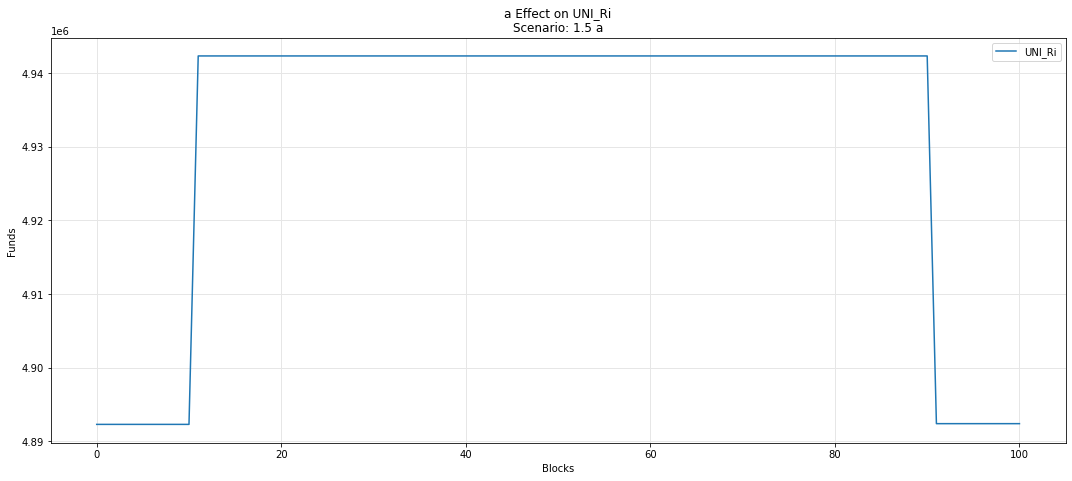

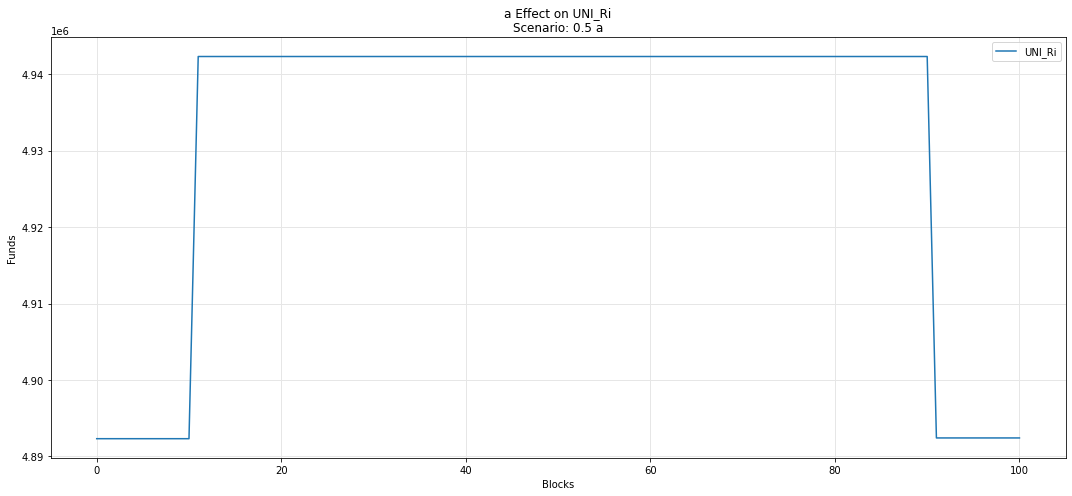

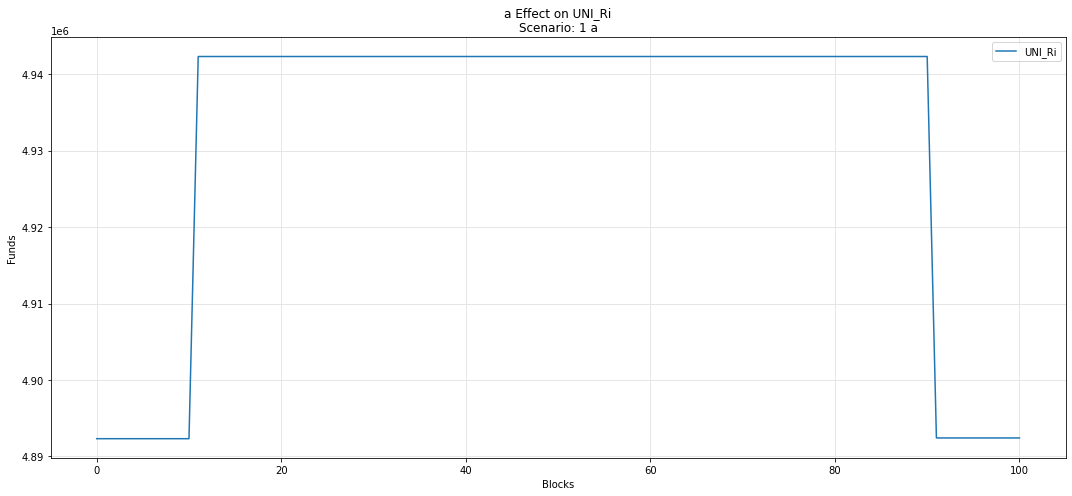

In [15]:
param_fan_plot2(experiments, config_ids, 'a', 'UNI_Ri')

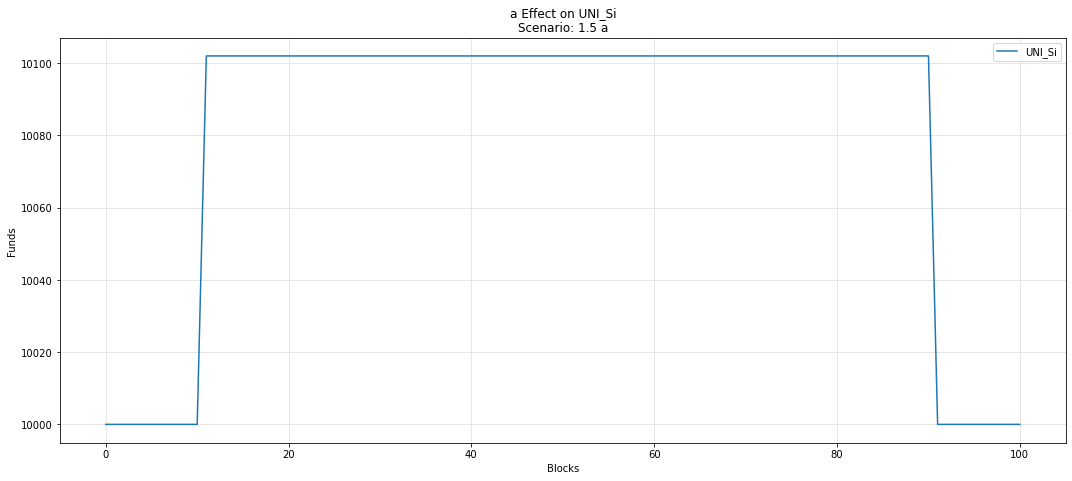

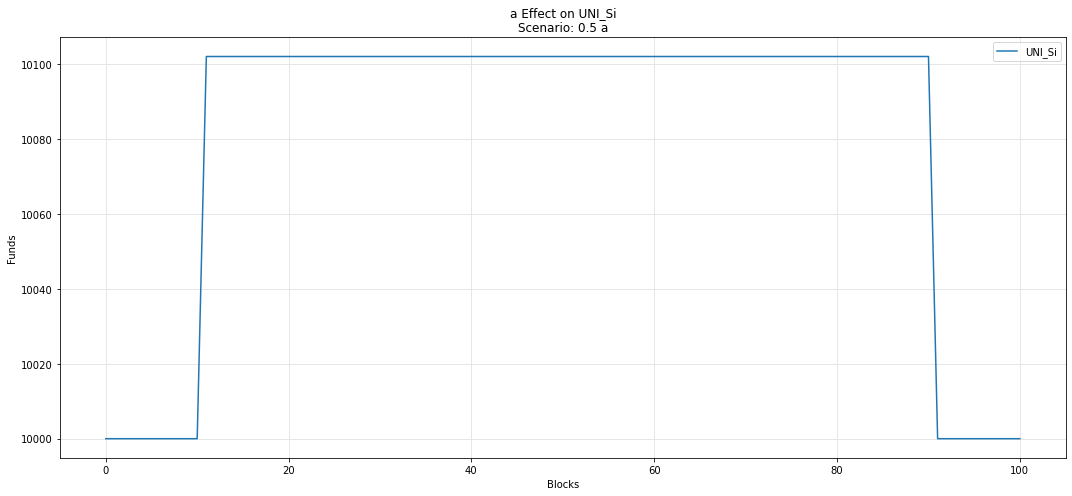

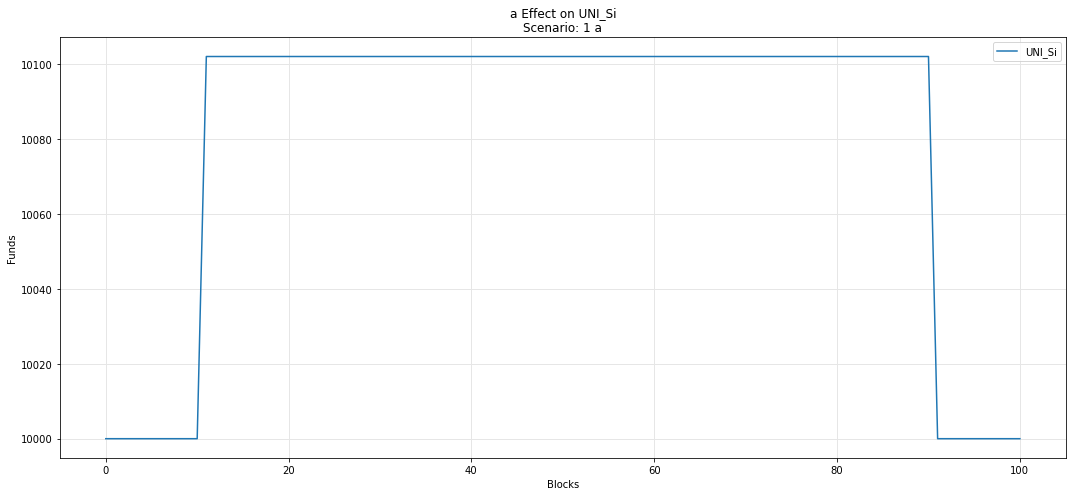

In [16]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Si', 'UNI_Si')

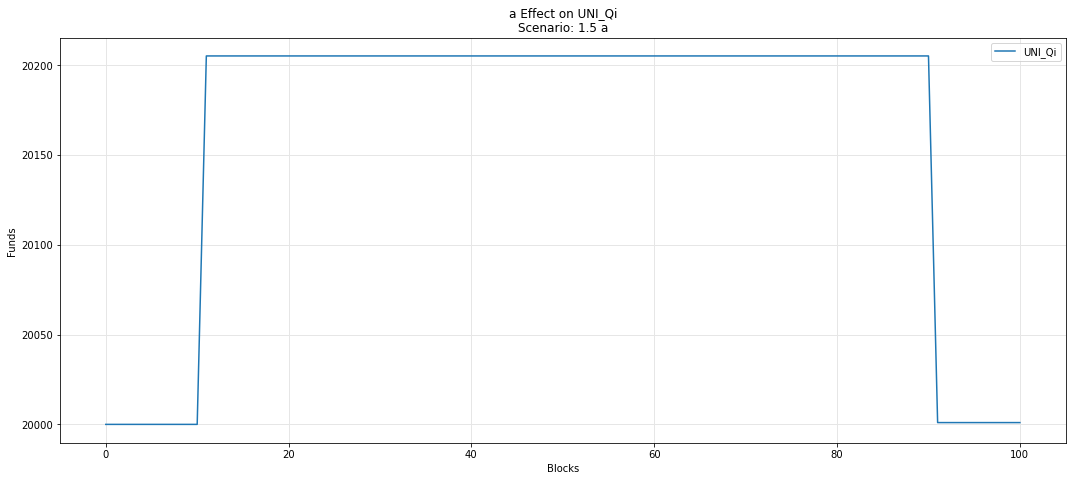

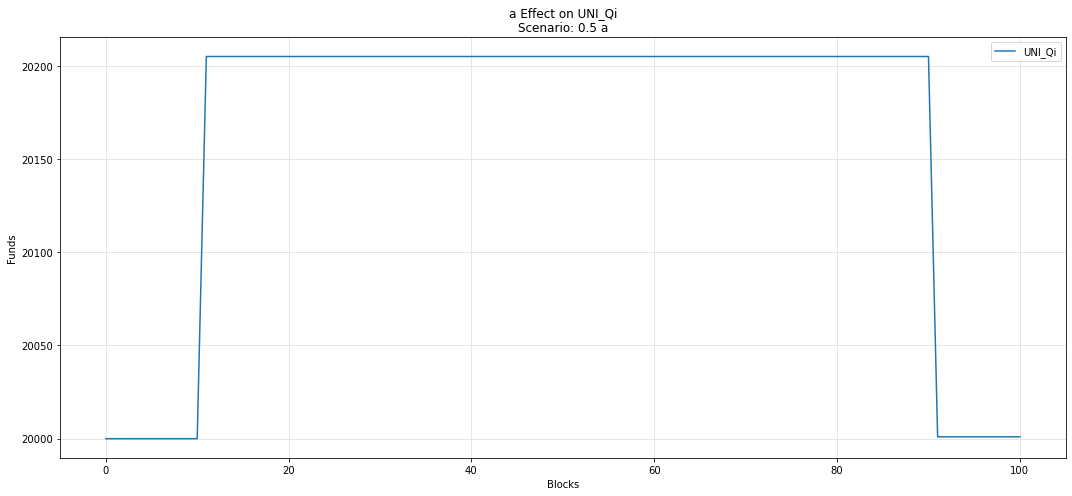

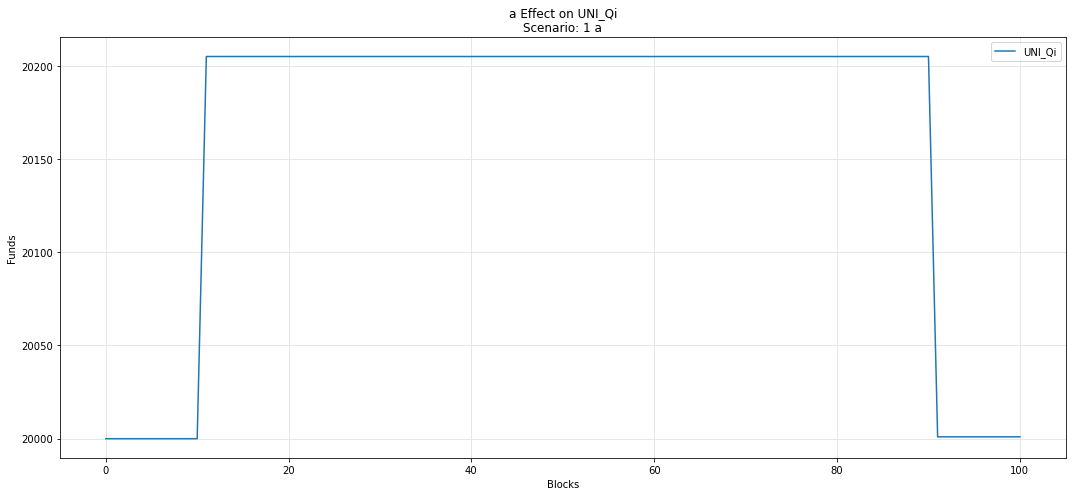

In [17]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Qi', 'UNI_Qi')

# Q - Rj instance

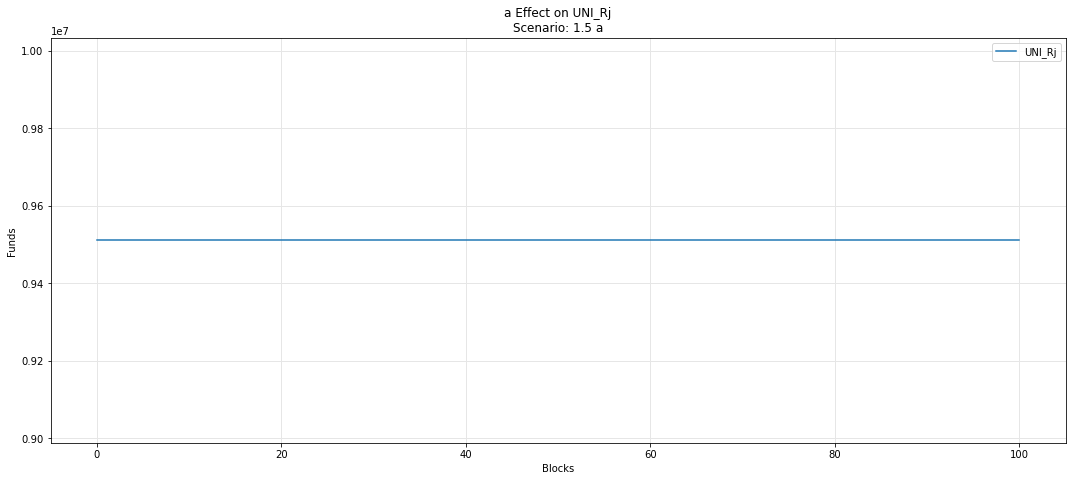

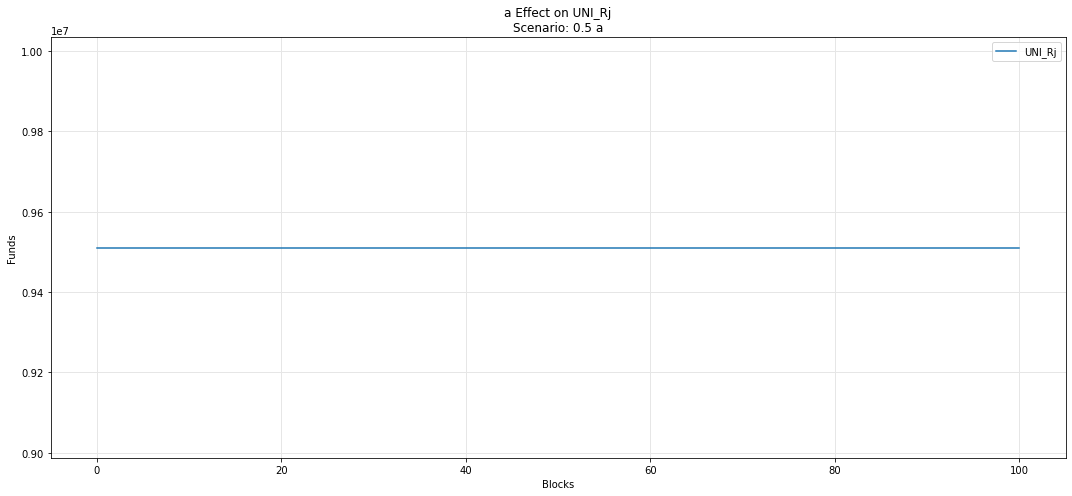

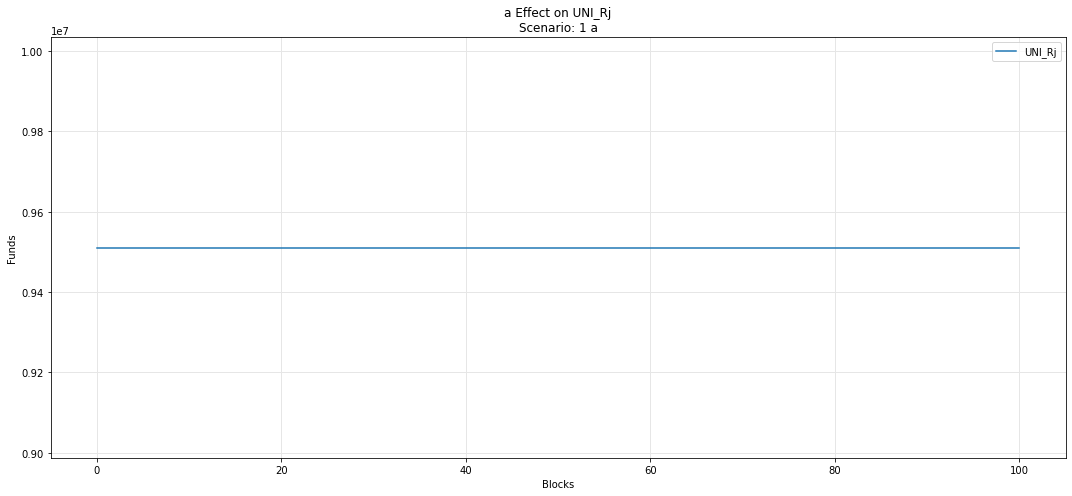

In [18]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Rj', 'UNI_Rj')

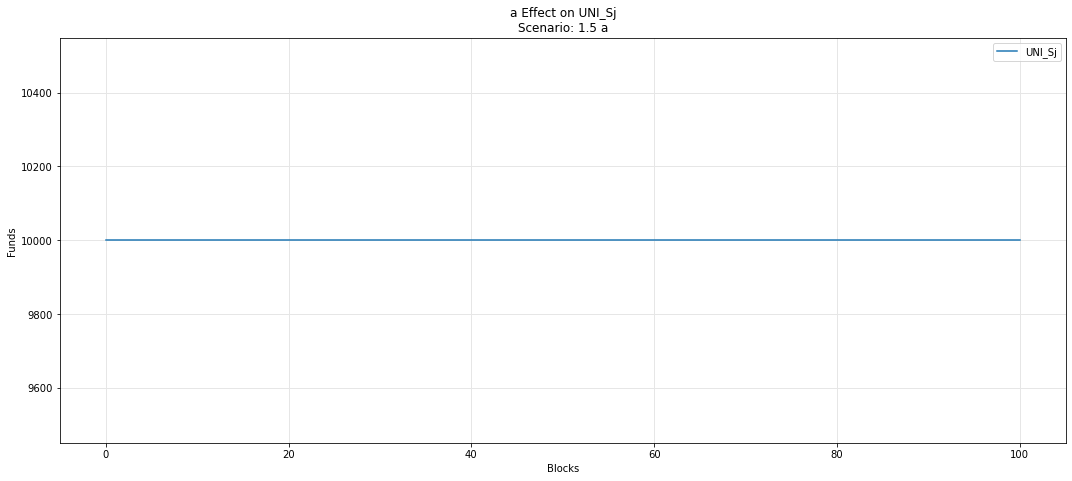

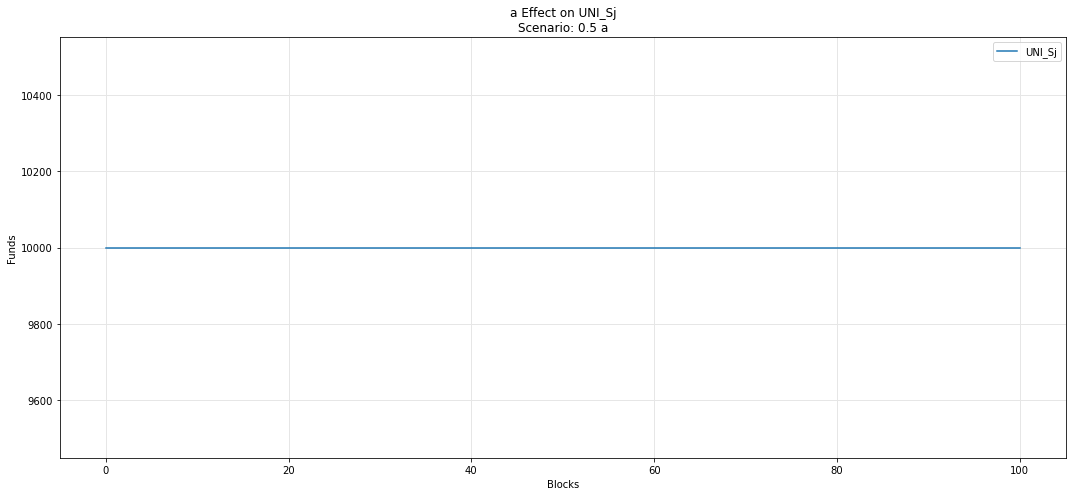

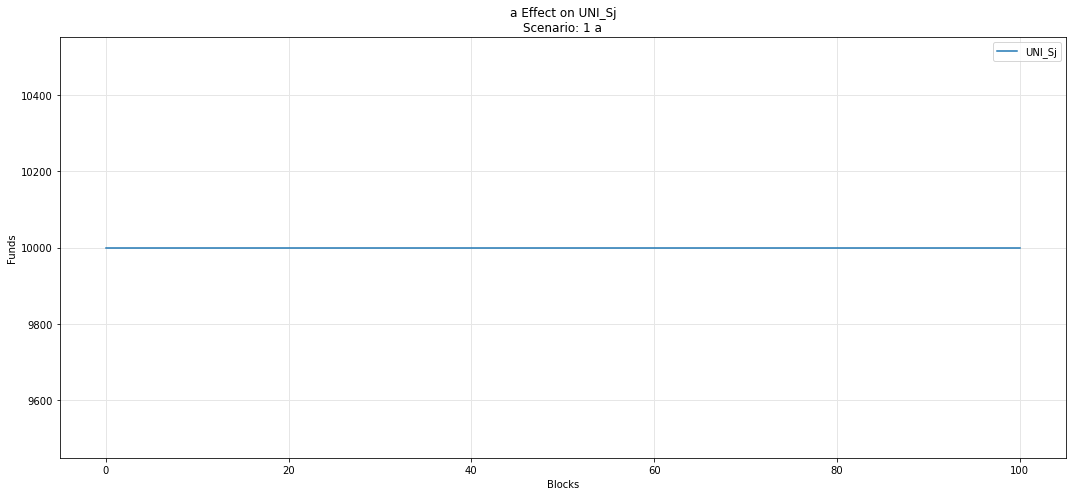

In [19]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Sj', 'UNI_Sj')

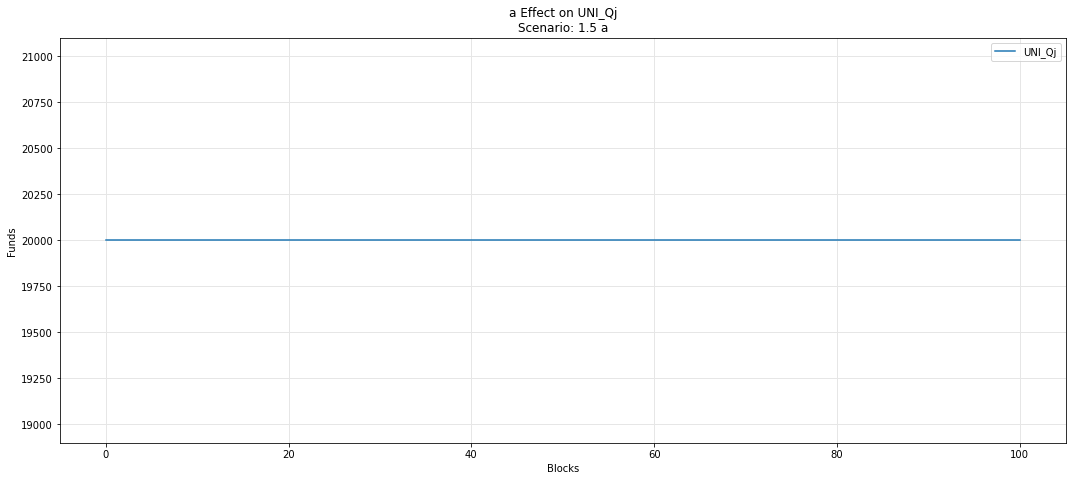

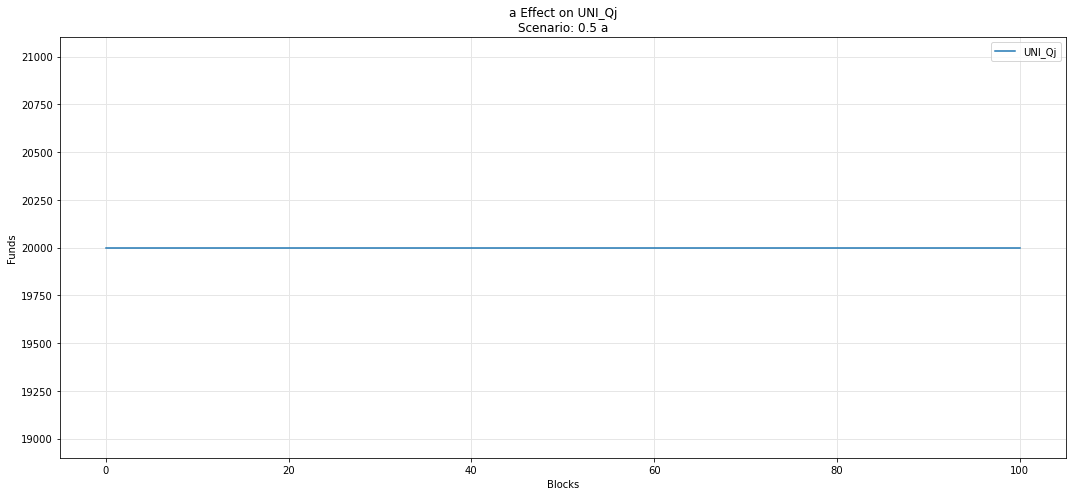

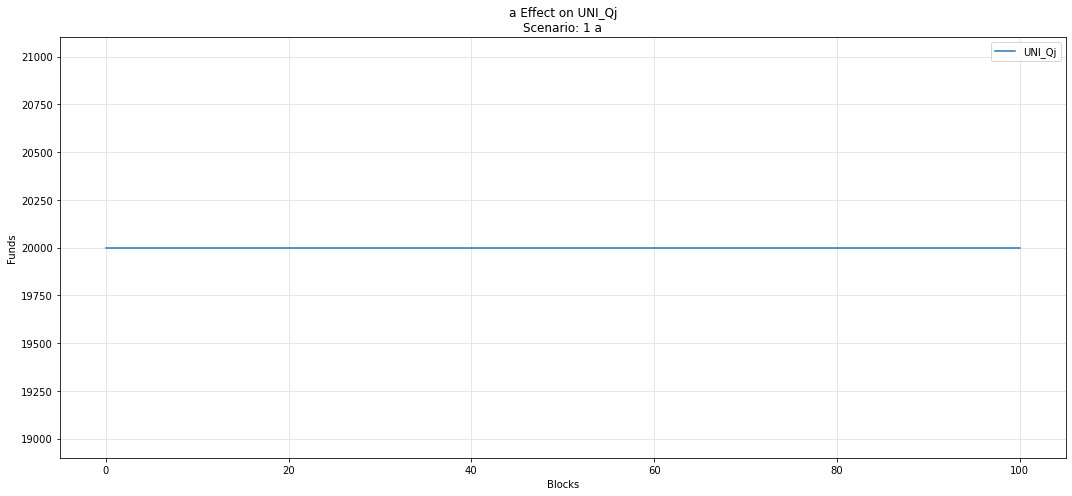

In [20]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Qj', 'UNI_Qj')

# ij - instance

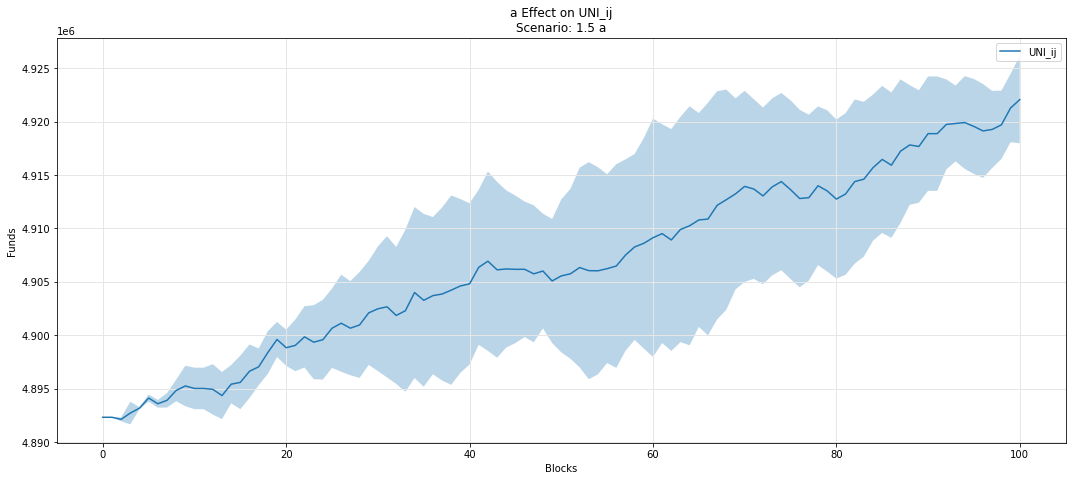

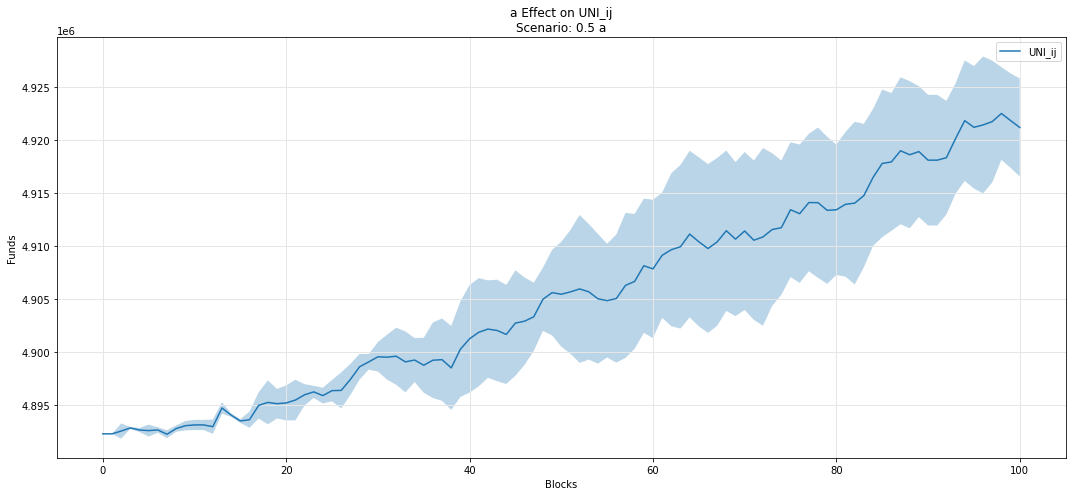

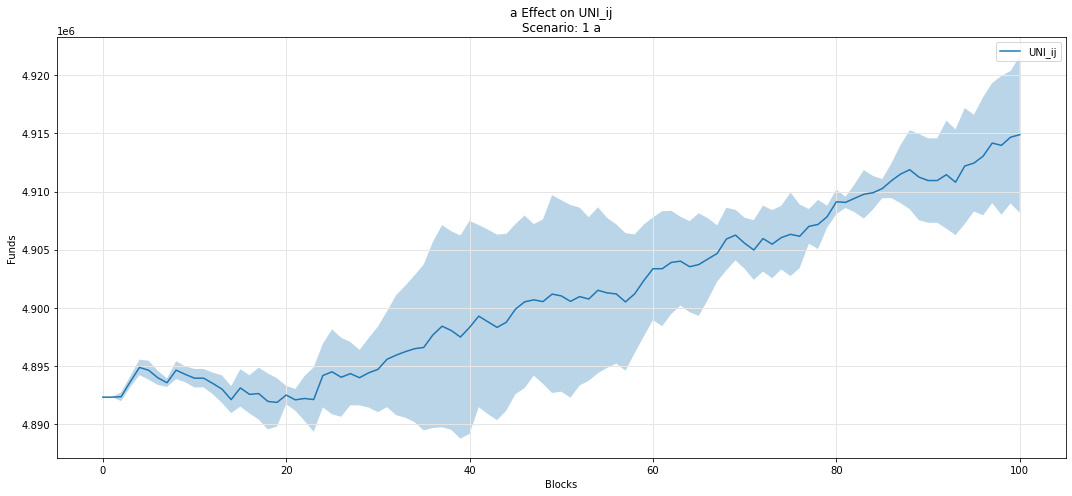

In [21]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_ij', 'UNI_ij')

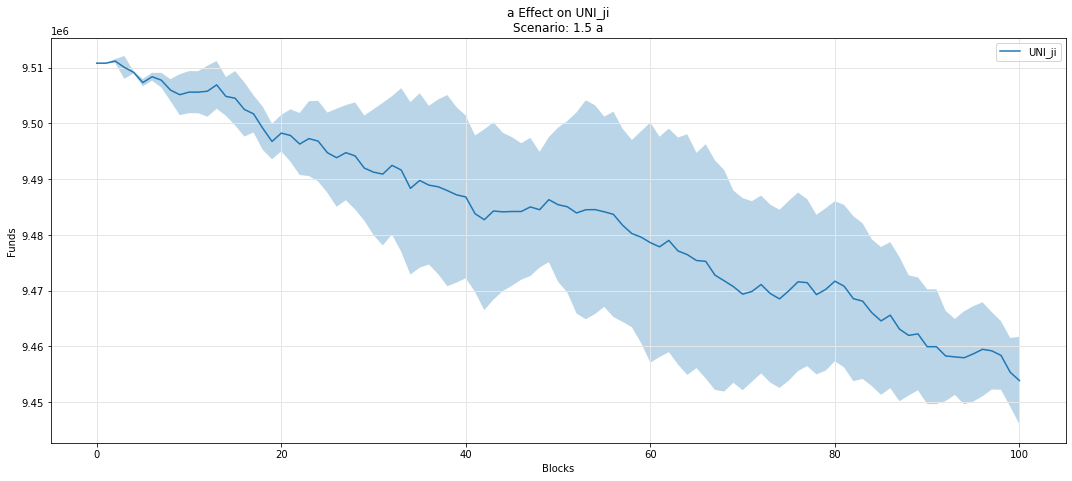

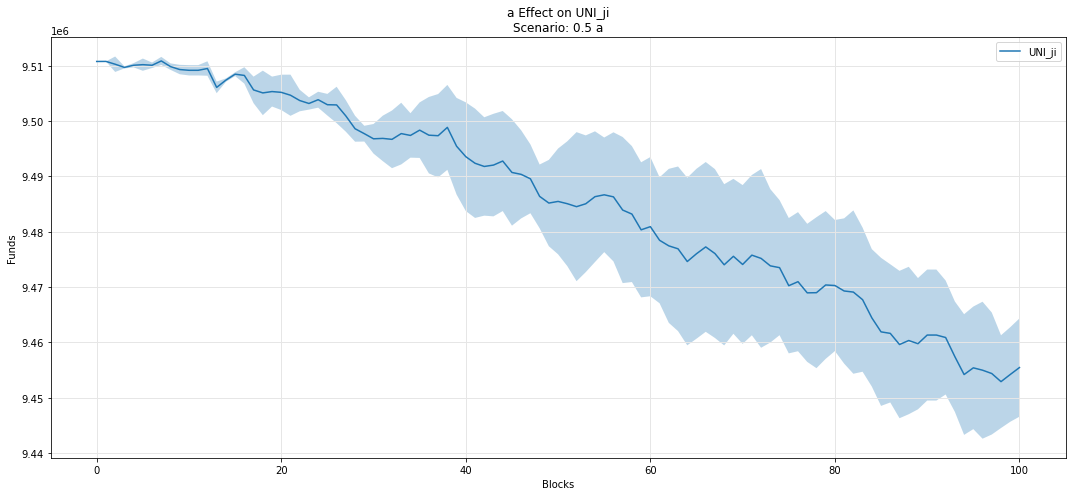

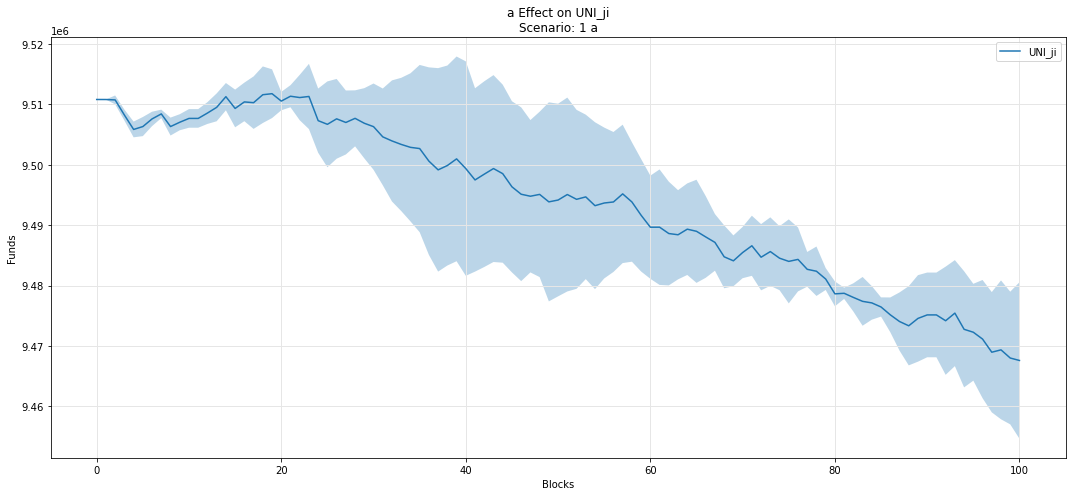

In [22]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_ji', 'UNI_ji')

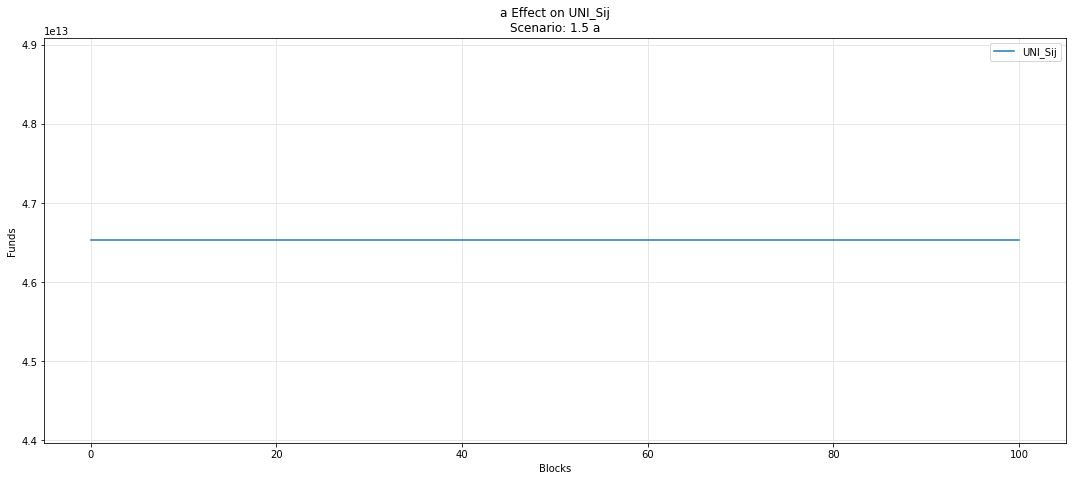

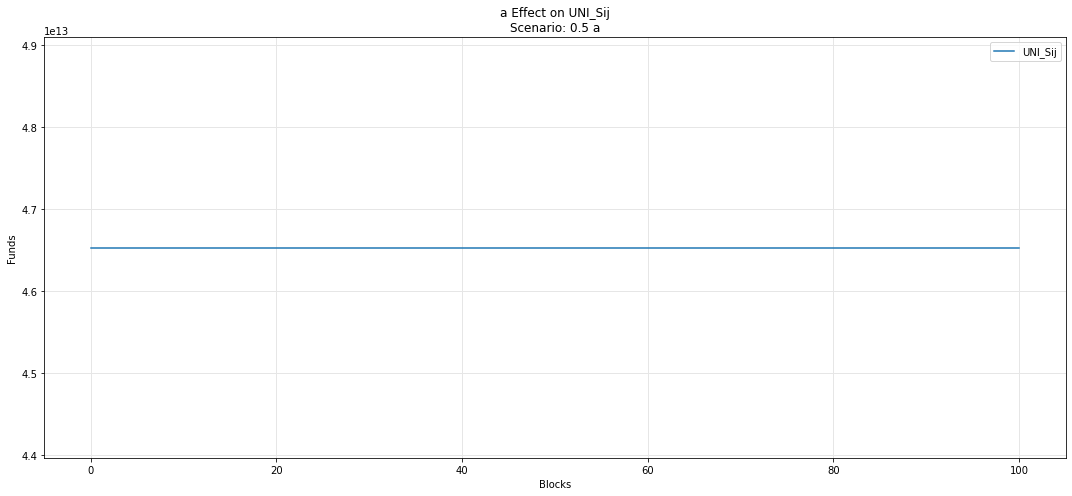

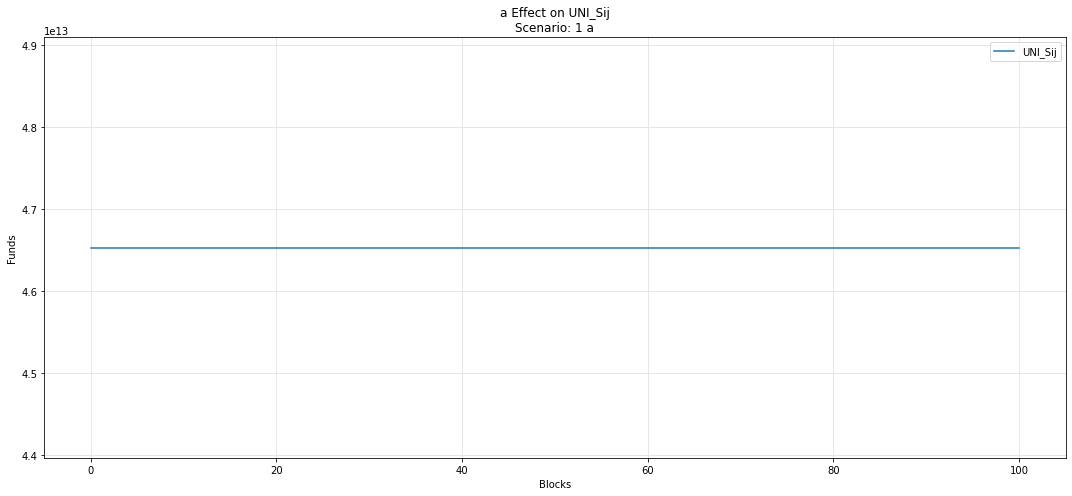

In [23]:
param_fan_plot(experiments, config_ids, 'a', 'UNI_Sij', 'UNI_Sij')

# Agents

## Uniswap

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


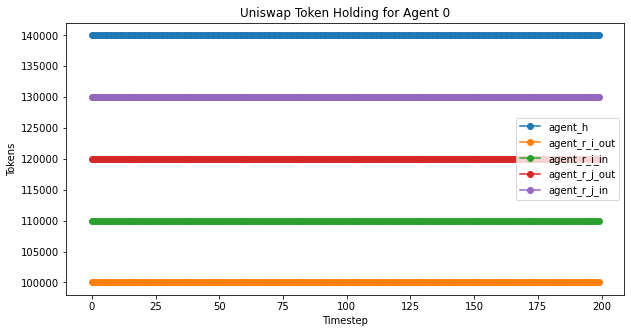

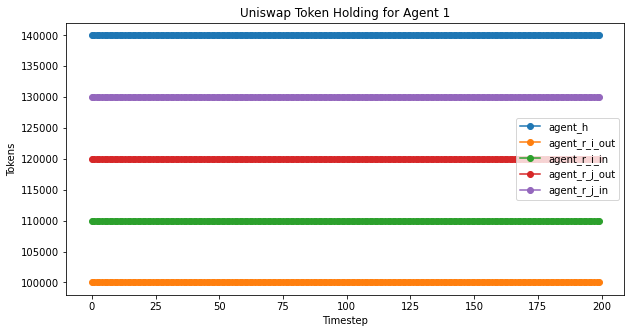

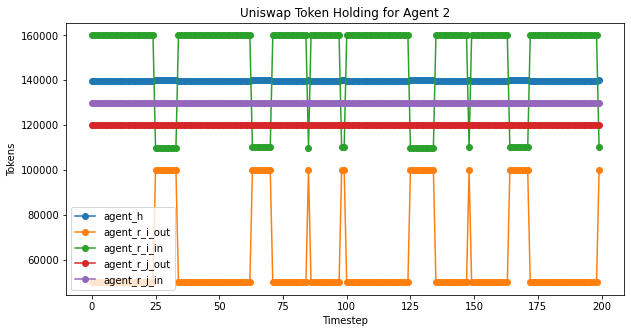

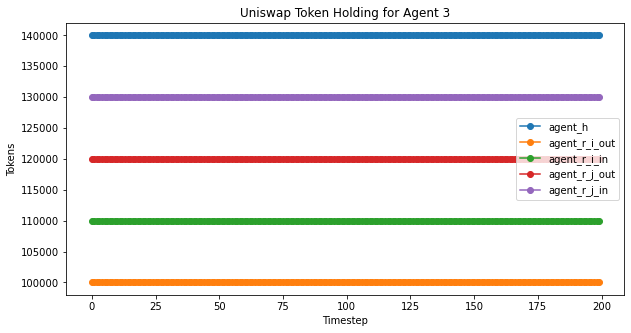

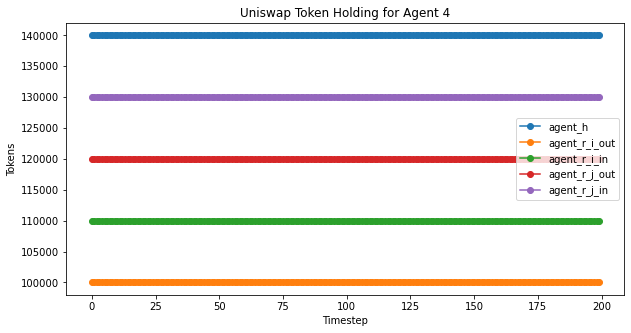

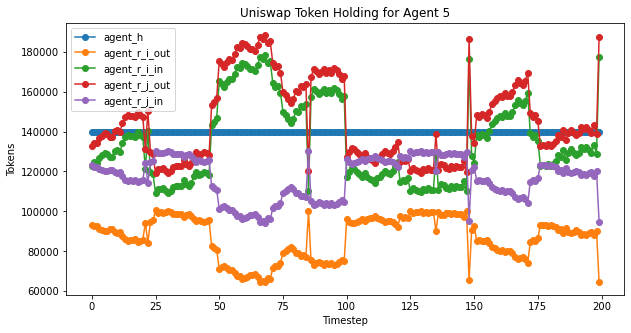

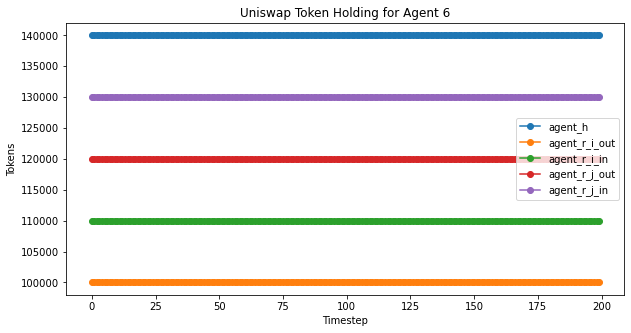

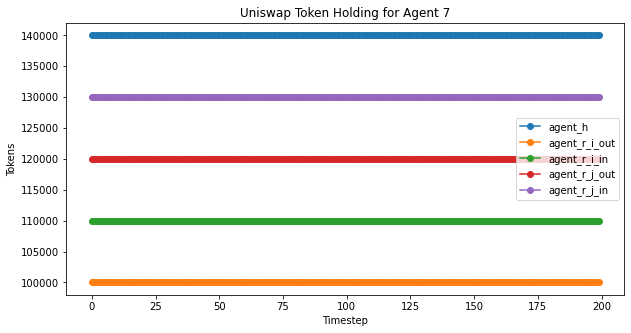

In [24]:
agent_plot(experiments,'Uniswap Token Holding for Agent ', 200) #,4,'j')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


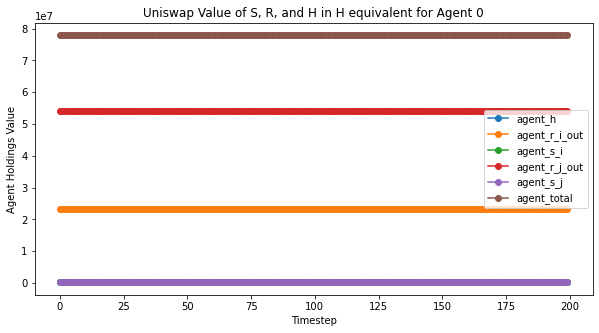

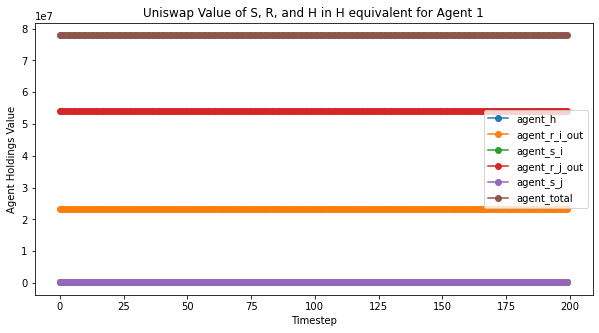

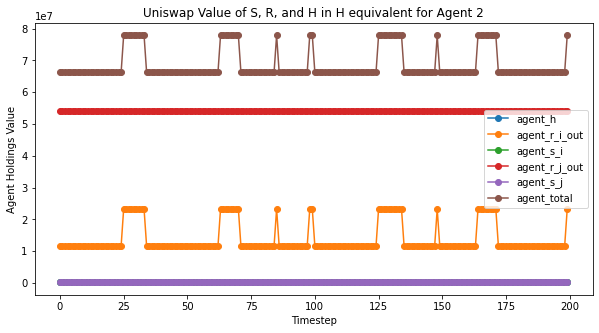

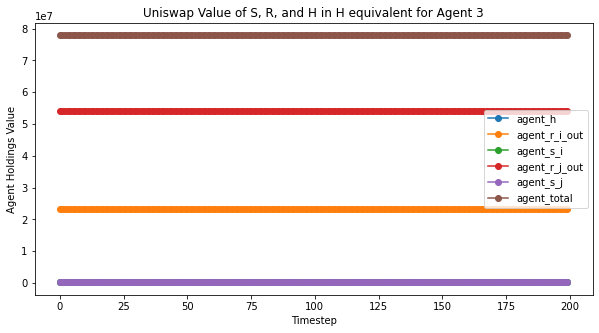

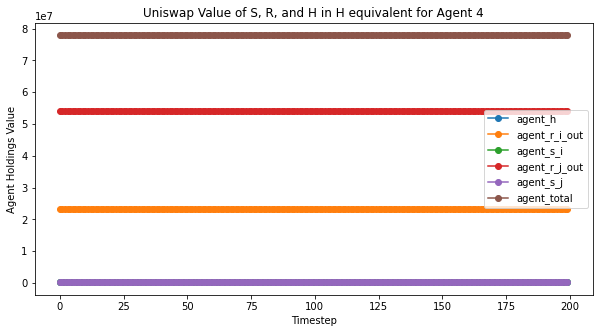

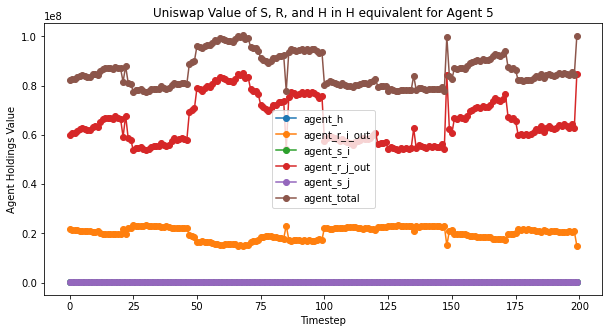

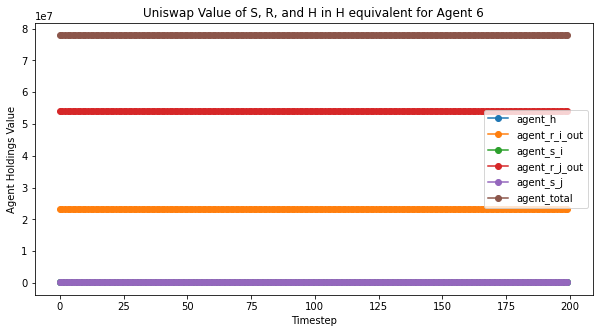

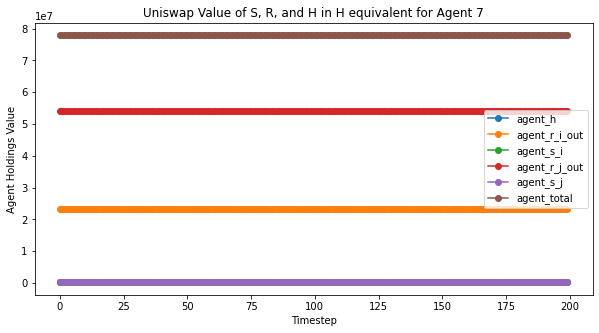

In [25]:
agent_value_plot(experiments,'Uniswap Value of S, R, and H in H equivalent', 200) #,2, 'i')

## Hydra

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


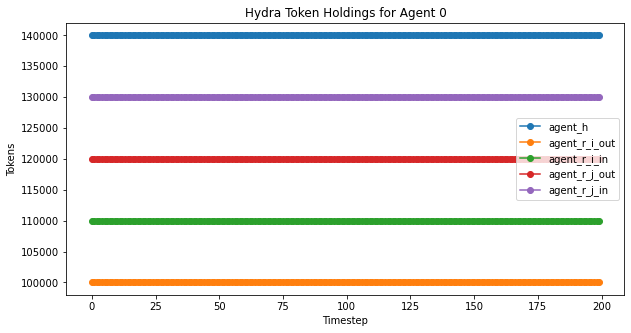

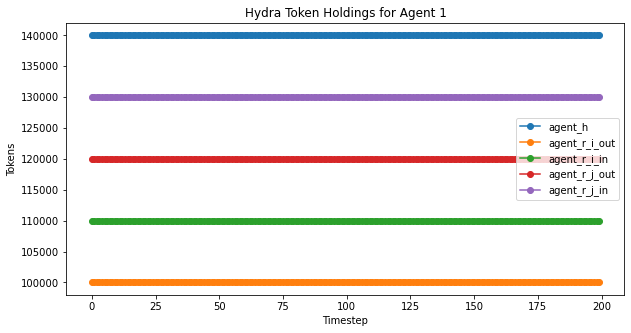

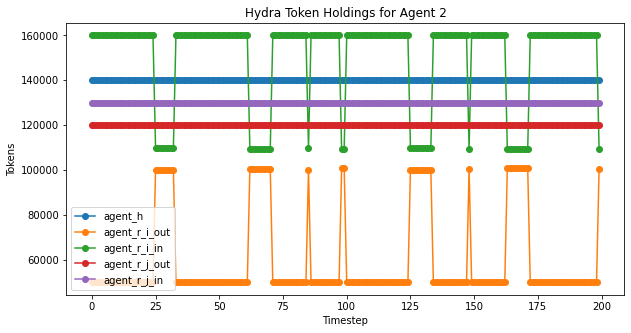

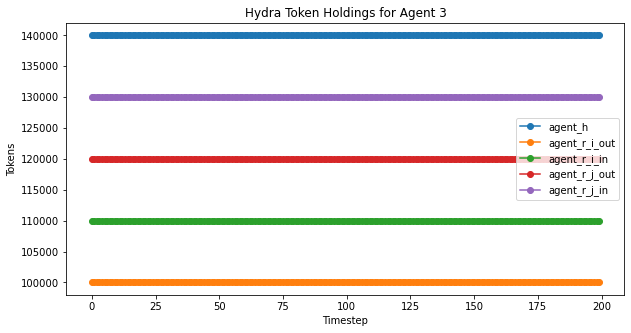

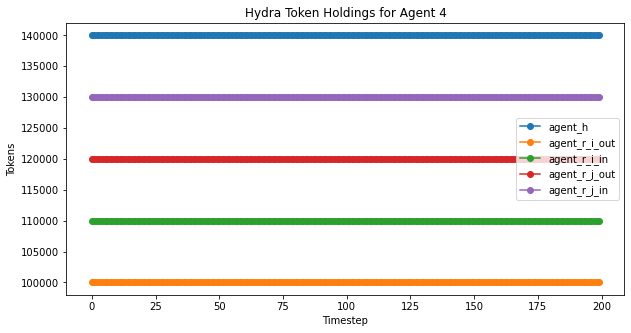

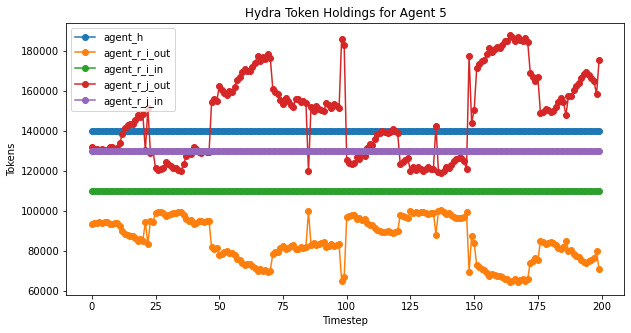

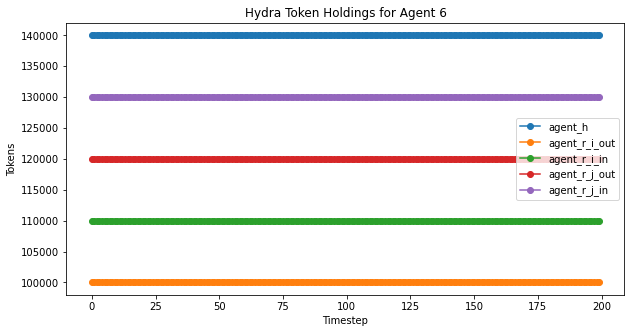

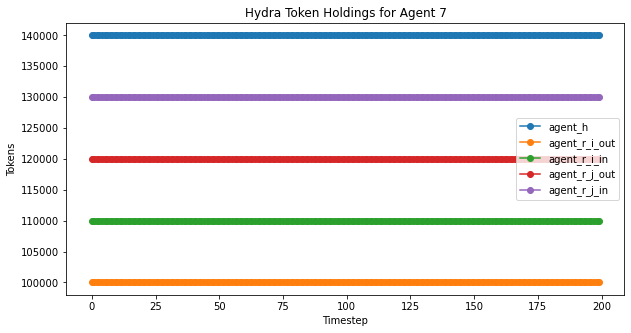

In [26]:
hydra_agent_plot(experiments,'Hydra Token Holdings for Agent ', 200)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


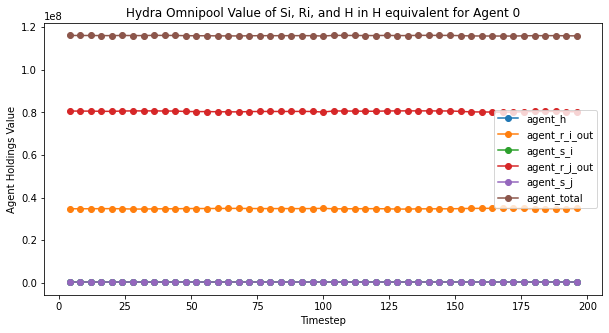

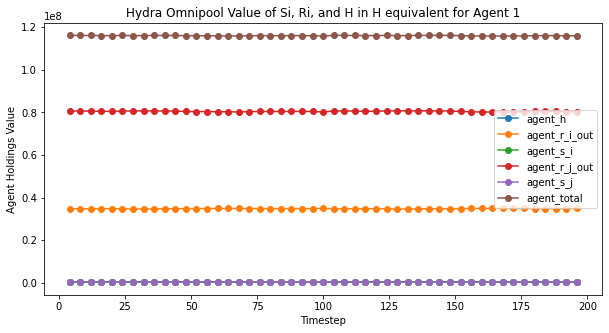

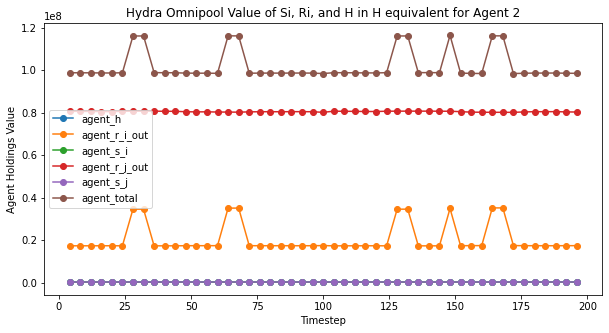

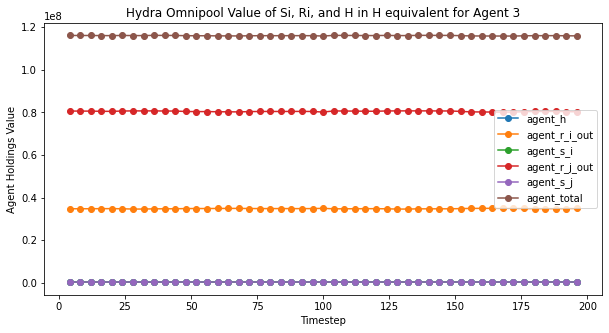

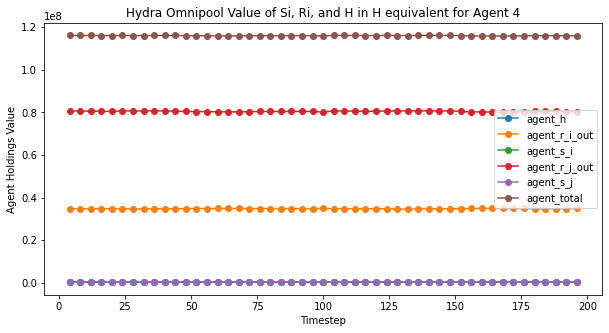

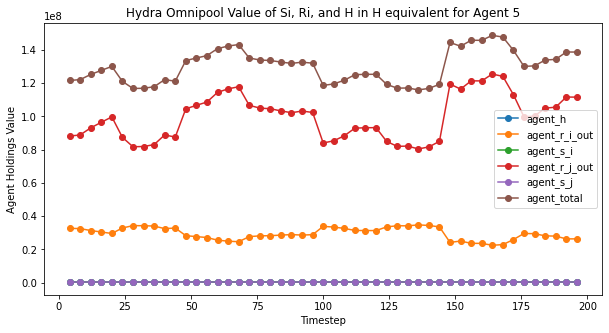

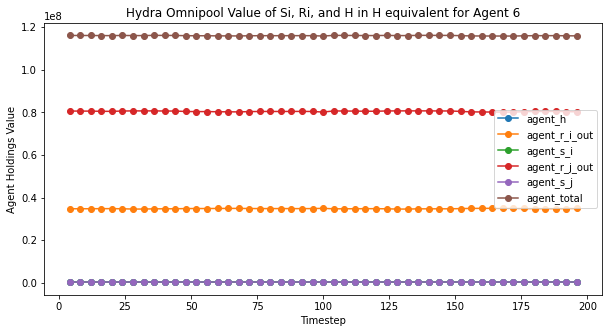

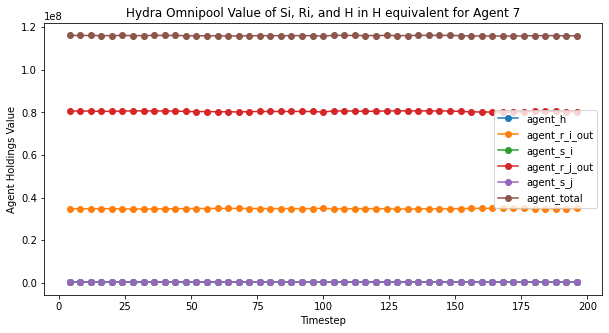

In [27]:
hydra_agent_value_plot(experiments,'Hydra Omnipool Value of Si, Ri, and H in H equivalent', 200) #,2, 'i')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


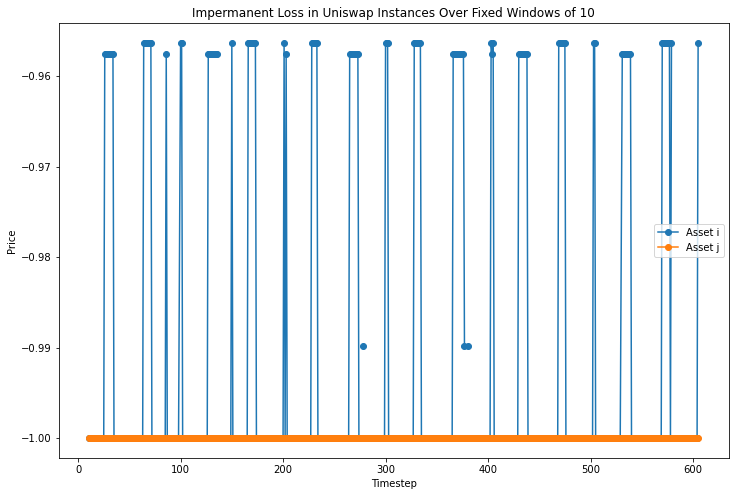

In [28]:
IL_plot(experiments,'Impermanent Loss in Uniswap Instances Over Fixed Windows of ', 10)

AttributeError: 'Asset' object has no attribute 'copy'

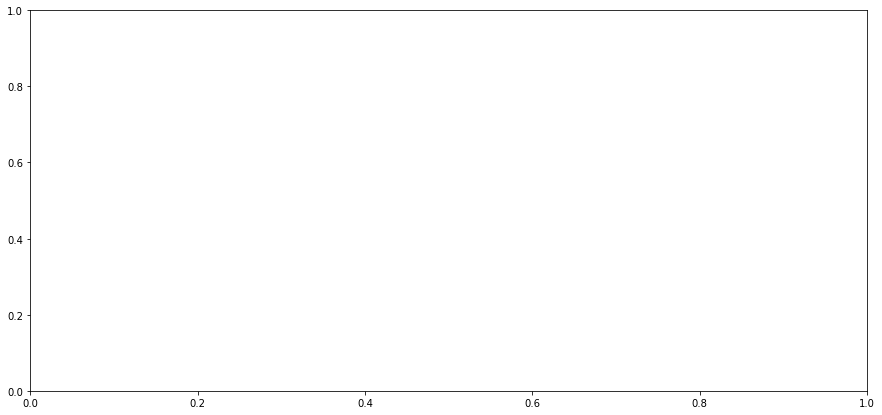

In [29]:
experiments = experiments.sort_values(by =['subset']).reset_index(drop=True)

cols = 1
rows = 1
cc_idx = 0

while cc_idx<len(experiments):
    cc = experiments.iloc[cc_idx]['pool']
    cc_label = experiments.iloc[cc_idx]['pool']
    secondary_label = experiments.iloc[cc_idx]['UNI_Ri'] # what is the sdry label here?
    sub_experiments = experiments[experiments['pool']==cc]
    cc_idx += len(sub_experiments)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15*cols,7*rows))
    sub_experiments.reset_index(drop=False)
    for i, experiment in sub_experiments.iterrows():
        df = experiment['pool'].copy()
        df['j_wallet'] = df.network.apply(lambda x: np.array(x.nodes['j']['wallet']))
        df['r_wallet'] = df.network.apply(lambda x: np.array(x.nodes['r']['wallet']))
        df['p_wallet'] = df.network.apply(lambda x: np.array(x.nodes['p']['wallet']))
        df['k_wallet'] = df.network.apply(lambda x: np.array(x.nodes['k']['wallet']))

        df['j_wallet'] = np.array(df.j_wallet,dtype = float)
        df['r_wallet'] = np.array(df.r_wallet,dtype = float)
        df['p_wallet'] = np.array(df.p_wallet,dtype = float)
        df['k_wallet'] = np.array(df.k_wallet,dtype = float)
        
        df_j = df.groupby('timestep').agg({'j_wallet': ['min', 'mean', 'max']}).reset_index()
        df_r = df.groupby('timestep').agg({'r_wallet': ['min', 'mean', 'max']}).reset_index()
        df_p = df.groupby('timestep').agg({'p_wallet': ['min', 'mean', 'max']}).reset_index()
        df_k = df.groupby('timestep').agg({'k_wallet': ['min', 'mean', 'max']}).reset_index()

        plot_label = experiment['AB_Test']
        ax = axs
        title = 'Tokens by Roles' + '\n' + 'Scenario: ' + str(cc_label*100)  + ' % Route Allocation, ' + \
                str(secondary_label*100)  + ' % Store Allocation'
        ax.set_title(title)
        ax.set_ylabel('Tokens')
        colors = ['b','orange', 'g', 'r']

        ax.plot(df_j.timestep, df_j['j_wallet']['mean'],color = colors[0], label='j_wallet')
        ax.plot(df_r.timestep, df_r['r_wallet']['mean'],color = colors[1],label='r_wallet')
        ax.plot(df_p.timestep, df_p['p_wallet']['mean'],color = colors[2],label='p_wallet')
        ax.plot(df_k.timestep, df_k['k_wallet']['mean'],color = colors[3],label='k_wallet')

        ax.legend()

        ax.fill_between(df_j.timestep, df_j[('j_wallet','min')], df_j[('j_wallet','max')], alpha=0.3 ,color = colors[0],label='j_wallet')        
        ax.fill_between(df_r.timestep, df_r[('r_wallet','min')], df_r[('r_wallet','max')], alpha=0.3 ,color = colors[1],label='r_wallet')        
        ax.fill_between(df_p.timestep, df_p[('p_wallet','min')], df_p[('p_wallet','max')], alpha=0.3 ,color = colors[2],label='p_wallet')        
        ax.fill_between(df_k.timestep, df_k[('k_wallet','min')], df_k[('k_wallet','max')], alpha=0.3 ,color = colors[3],label='k_wallet')        
         
        ax.set_xlabel('Blocks')
        ax.grid(color='0.9', linestyle='-', linewidth=1)

        plt.tight_layout()
        
fig.tight_layout(rect=[0, 0, 1, .97])
fig.patch.set_alpha(1)
display(fig)
plt.close()

In [ ]:
pd.read_pickle ('C:/Users/paruc/Documents/Github/hydra/hydra_multi_class/experiment_block1_test_20210427.pkl')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 1000
x = np.linspace(0, 10, N)
y = x**2
ones = np.ones(N)

vals = [30, 20, 10] # Values to iterate over and add/subtract from y.

fig, ax = plt.subplots()

for i, val in enumerate(vals):
    alpha = 0.5*(i+1)/len(vals) # Modify the alpha value for each iteration.
    ax.fill_between(x, y+ones*val, y-ones*val, color='red', alpha=alpha)

ax.plot(x, y, color='red') # Plot the original signal

plt.show()

In [ ]:
agent_plot(experiments,'Uniswap Token Holding for Agent ', 100) #,4,'j')

In [ ]:
hydra_agent_plot(experiments,'Hydra Token Holdings for Agent ', 100)

In [ ]:
experiments['hydra_agents'][400]

How to 
- extract particular data from the dataframe, conditioned on an attribute selection 
- sort data in this new dataframe

In [ ]:
experiments1.loc[experiments['subset'] == 1].sort_values(by =['index'])

How then further select particular entries from this dataframe:
- by defining colomn (?) and row (?)

In [ ]:
#experiments1.loc[experiments['subset'] == 1].sort_values(by =['index'])['index'][101]

How then further select entries by column and row number ?

In [ ]:
experiments1.loc[experiments['subset'] == 1].sort_values(by =['index']).iloc[0][2]

In [ ]:
np.linspace(0, 10, N)

In [ ]:
list(range(0, 5))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(0, 5))
y = experiments1.loc[experiments['subset'] == 1].sort_values(by =['index']).iloc[2][x]
fig, ax = plt.subplots()
ax.plot(x, y, color='red') # Plot the original signal

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 1000
x = list(range(0, 5))
y = experiments1.loc[experiments['subset'] == 1].sort_values(by =['index']).iloc[0][x]
ones = np.ones(N)

vals = [30, 20, 10] # Values to iterate over and add/subtract from y.

fig, ax = plt.subplots()

for i, val in enumerate(vals):
    alpha = 0.5*(i+1)/len(vals) # Modify the alpha value for each iteration.
    ax.fill_between(x, y+ones*val, y-ones*val, color='red', alpha=alpha)

ax.plot(x, y, color='red') # Plot the original signal

plt.show()